# PROJET RAKUTEN

# Installation des packages et import des données

In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=2865f4648cadc1534410416fb268915162ac4f97b54aa438dedaf5c3776d0b65
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00


In [3]:
#(1)Importer google drive dans le projet

from google.colab import drive
drive.mount('/content/drive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found


In [4]:
#(2) Importer les packages
import os
import re
import nltk
import glob
import string
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import itertools

from collections import Counter
from textblob import TextBlob
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import wordnet,stopwords
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from transformers import BertTokenizer, TFBertModel, CamembertTokenizerFast, TFCamembertModel

from sklearn.metrics import accuracy_score, precision_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

from scipy.ndimage import median_filter
from natsort import natsort_keygen
from PIL import Image
import zipfile
import imghdr
import scipy.sparse as sp

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input, Dropout, LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [5]:
# Librairies pour traitement de texte
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
#(3) Chargement des fichiers

X_train = pd.read_csv('/content/drive/MyDrive/X_train_update.csv'  , index_col=0)
y_train = pd.read_csv('/content/drive/MyDrive/Y_train_CVw08PX.csv' , index_col=0)
X_test  = pd.read_csv('/content/drive/MyDrive/X_test_update.csv'   , index_col=0)

# Préparation du dataset

In [17]:
#(4) Fusion de X_train et y_train dans un DataFrame

df = pd.concat([X_train, y_train], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


In [18]:
#(5) Identification et suppression des doublons

def get_file_names(folder_path):
    file_names  = []
    folder_name = []
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            file_names.append(file)
            folder_name.append(folder_path.split("/")[-1])
    return file_names, folder_name

folder_paths = [
    '/content/drive/MyDrive/Train_1',
    '/content/drive/MyDrive/Train_2',
    '/content/drive/MyDrive/Train_3',
    '/content/drive/MyDrive/Train_4',
    '/content/drive/MyDrive/Train_5',
    '/content/drive/MyDrive/Train_6',
    '/content/drive/MyDrive/Train_7',
    '/content/drive/MyDrive/Train_8'
]

file_names  = []
folder_name = []
for folder_path in folder_paths:
    names, folders = get_file_names(folder_path)
    file_names.extend(names)
    folder_name.extend(folders)

image_train = pd.DataFrame({'image_name' : file_names, 'folder_name' : folder_name})

# Vérification des doublons dans le DataFrame entier
duplicates = image_train[image_train.duplicated(keep=False)]
print("Doublons dans le DataFrame :")
print(duplicates)

image_train['temp'] = image_train['image_name'].str.split('_')

image_train['prefix'] = image_train['temp'].str[0]
image_train['number'] = image_train['temp'].str[1]
image_train['suffix'] = image_train['temp'].str[-1]

image_train = image_train.drop('temp', axis=1)

# Vérification des doublons dans la colonne "number"
duplicates_number = image_train['number'].duplicated(keep=False)
if duplicates_number.any():
    print("Doublons dans la colonne 'number' :")
    print(image_train[duplicates_number])
else:
    print("Aucun doublon dans la colonne 'number'.")

# Création d'une condition qui sélectionne toutes les lignes dont le nom de l'image contient "(1)"
condition = image_train['image_name'].str.contains('\(1\)')

# Suppression de toutes les lignes qui correspondent à la condition
image_train = image_train[~condition]

print("Taille du DataFrame image_train :", image_train.shape)
image_train.head(15)

Doublons dans le DataFrame :
Empty DataFrame
Columns: [image_name, folder_name]
Index: []
Doublons dans la colonne 'number' :
                                        image_name folder_name prefix  \
20873    image_984672077_product_289454837 (1).jpg     Train_3  image   
20888        image_984672077_product_289454837.jpg     Train_3  image   
23079  image_1066931053_product_1173353297 (1).jpg     Train_3  image   
23276      image_1066931053_product_1173353297.jpg     Train_3  image   
24032   image_1008229059_product_436165091 (1).jpg     Train_3  image   
24080       image_1008229059_product_436165091.jpg     Train_3  image   
24845  image_1069680878_product_1253949463 (1).jpg     Train_3  image   
24862      image_1069680878_product_1253949463.jpg     Train_3  image   
26235   image_1010253217_product_445454465 (1).jpg     Train_3  image   
26242       image_1010253217_product_445454465.jpg     Train_3  image   
26788   image_1027231699_product_570642970 (1).jpg     Train_3  image  

,image_name,folder_name,prefix,number,suffix
0,image_847451624_product_76360775.jpg,Train_1,image,847451624,76360775.jpg
1,image_937538692_product_198255029.jpg,Train_1,image,937538692,198255029.jpg
2,image_873029255_product_118484596.jpg,Train_1,image,873029255,118484596.jpg
3,image_898727867_product_89938469.jpg,Train_1,image,898727867,89938469.jpg
4,image_925093248_product_66432546.jpg,Train_1,image,925093248,66432546.jpg
5,image_947358221_product_209339122.jpg,Train_1,image,947358221,209339122.jpg
6,image_936461285_product_195897867.jpg,Train_1,image,936461285,195897867.jpg
7,image_917469307_product_152660586.jpg,Train_1,image,917469307,152660586.jpg
8,image_927964349_product_181256309.jpg,Train_1,image,927964349,181256309.jpg
9,image_835522819_product_49536693.jpg,Train_1,image,835522819,49536693.jpg


In [ ]:
#(6) Import des images test
# Spécifier le chemin d'accès au dossier
folder_path = '/content/drive/MyDrive/image_test'

# Obtenir les noms de fichiers
file_names = get_file_names(folder_path)

# Créer un DataFrame avec les noms des fichiers
image_test = pd.DataFrame({'image_name' : file_names})

print("Taille du DataFrame image_test : ", image_test.shape)

Taille du DataFrame image_test :  (2, 1)


In [19]:
#(7) Convertir les colonnes spécifiées en chaînes de caractères
df = df.astype({'productid' : 'str', 'imageid' : 'str'})

#(8a) Créer une nouvelle colonne "img_pd" en appliquant une fonction lambda à chaque ligne
df['img_pd'] = df.apply(lambda row : "image_" + row['imageid'] + "_product_" + row["productid"] + ".jpg" , axis=1)

#(8b) Trier df suivant le même ordre adopté par le système (Windows ou Mac)
nkey = natsort_keygen()
df = df.sort_values(by = 'img_pd', key = lambda x : x.map(nkey))

df.iloc[5]

# Afficher le DataFrame mis à jour
df.head()

,designation,description,productid,imageid,prdtypecode,img_pd
61479,Bien Enchérir En Attaque,NaN,365202,67284,10,image_67284_product_365202.jpg
64904,Toonstein : Le Château Hante,NaN,184251,234234,40,image_234234_product_184251.jpg
45140,Knock Out Kings 2000,NaN,184752,234381,40,image_234381_product_184752.jpg
60943,Mtv Music Generator 2,NaN,853823,414480,40,image_414480_product_853823.jpg
38871,Diablo Ii [Coffret Édition Limitée],NaN,929166,482710,40,image_482710_product_929166.jpg


# Analyse initiale du data set

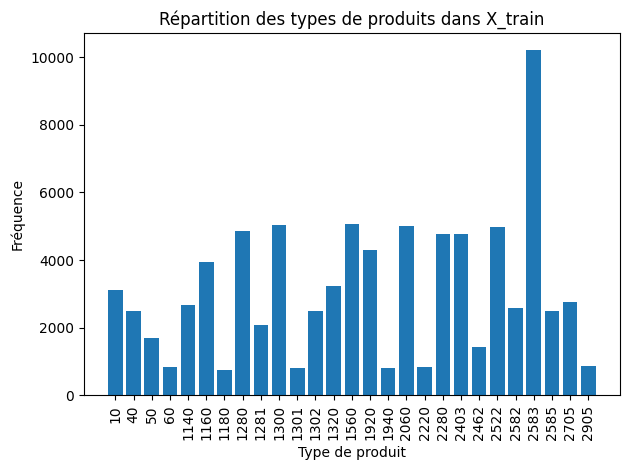

Répartition des types de produits dans X_train


In [20]:
#(9) Répartition des produits sur les catégories
# Nombre de barres pour l'histogramme
nb_pdtype = len(df.prdtypecode.value_counts().index)

# Fréquence prdtypecode triées par ordre ascendant selon l'index
freq_pdtype = df['prdtypecode'].value_counts().sort_index().values

# Modalités prdtypecode triées par ordre ascendant
mod_pdtype = df['prdtypecode'].value_counts().sort_index().index
mod_pdtype_int=[int(element) for element in mod_pdtype]
mod_triees=sorted(mod_pdtype_int)
# Légende du graphique

plt.title("Répartition des types de produits dans X_train")
plt.bar(range(nb_pdtype), freq_pdtype)
plt.xticks(range(nb_pdtype), mod_triees, rotation = 'vertical')
plt.xlabel('Type de produit')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/photos_rapport/repartition_produits.png')
plt.show()

print("Répartition des types de produits dans X_train")




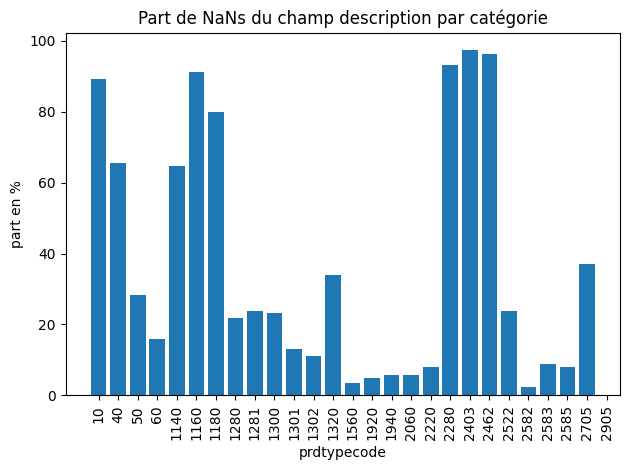

Nom du graphique : Part de NaNs du champ description par catégorie


In [21]:
#(10) Part des NaNs par catégorie
# Répartition des NaNs par catégorie
df_nan = df[df['description'].isna()]
grouped_prdtypecode = df.groupby(['prdtypecode']).size()

# Agrégation par catégorie
repart_nans = df_nan.groupby('prdtypecode').size() / grouped_prdtypecode * 100

# Changement du type d'index en entier
repart_nans.index = repart_nans.index.astype(int)

# Isolation des modalités vs fréquences
mod_nans = repart_nans.sort_index().index
freq_nans = repart_nans.sort_index().values

# Légende graphique

plt.bar(range(len(repart_nans)), freq_nans)
plt.xticks(range(len(repart_nans)), mod_nans, rotation='vertical')
plt.xlabel('prdtypecode')
plt.ylabel('part en %')
plt.title("Part de NaNs du champ description par catégorie")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/photos_rapport/part_nans.png')
plt.show()

print("Nom du graphique : Part de NaNs du champ description par catégorie")


# Analyse textuelle du data set

In [22]:
#(11) fusionner designation et description en 'description_complete'
# Regrouper les colonnes designation et description

df['description_complete'] = df['designation'].fillna('') + ' ' + df['description'].fillna('')
df.head(1)

,designation,description,productid,imageid,prdtypecode,img_pd,description_complete
61479,Bien Enchérir En Attaque,NaN,365202,67284,10,image_67284_product_365202.jpg,Bien Enchérir En Attaque


In [23]:
#(12) Changement des NaN de description par du vide

df['description'] = df['description'].fillna('')
df.head()

,designation,description,productid,imageid,prdtypecode,img_pd,description_complete
61479,Bien Enchérir En Attaque,,365202,67284,10,image_67284_product_365202.jpg,Bien Enchérir En Attaque
64904,Toonstein : Le Château Hante,,184251,234234,40,image_234234_product_184251.jpg,Toonstein : Le Château Hante
45140,Knock Out Kings 2000,,184752,234381,40,image_234381_product_184752.jpg,Knock Out Kings 2000
60943,Mtv Music Generator 2,,853823,414480,40,image_414480_product_853823.jpg,Mtv Music Generator 2
38871,Diablo Ii [Coffret Édition Limitée],,929166,482710,40,image_482710_product_929166.jpg,Diablo Ii [Coffret Édition Limitée]


In [24]:
#(13) Remplacement du descriptif inutile par NaN
# Définition de la valeur bidon
valeur_bidon = "Attention !!! Ce produit est un import si les informations 'langues' et 'sous-titres' n'apparaissent pas sur cette fiche produit c'est que l'éditeur ne nous les a pas fournies. Néanmoins dans la grande majorité de ces cas il n'existe ni langue ni sous titres en français sur ces imports."

# Transformation initiale
df['description_complete'] = df['description_complete'].apply(lambda x: np.nan if valeur_bidon in str(x) else x)

# Remplacement des NaN par des chaînes vides
df['description_complete'].fillna('', inplace = True)

# Affichage du compte des valeurs
print(df['description_complete'].value_counts())

Poignée Design Impression Numérique 3d Full Polyester Tissu Oxford Picnic Mat / Beac Stream Poignée de conception 3D Impression numérique pleine Polyester Tissu Oxford Mat pique-nique / plage MatProduct point de vente: tapis impression numérique 3D complète polyester pique-nique en tissu Oxford / tapis de plage / tapis d&#39;humidité par rapport à l&#39;avantage du tapis de pique-nique habitude assez grand pour vous permettre de vous et votre famille ou entre amis profiter le glamour de la nature. Conçu avec une poignée de transport la couverture peut être facilement plié en forme de sac à main. lavable résistant aux taches et imperméable à l&#39;eau antifraying fadeless. emballage léger et pliable facile à carry.Simple format A4 facile à transporter entièrement imperméable à l&#39;eau et faciles à porter beau modèle forte impression numérique 3D fort sens de la nécessité trois dimensionalA pour le camping barbecue de pique-nique et d&#39;autres activités de plein air et jardin. Caract

In [25]:
#(14) Nombre de mots dans le champ description_complete
# Créer une nouvelle colonne 'nbmots_designation'
df['nbmots_designation'] = df['description_complete'].apply(lambda x: len(str(x).split()) if not pd.isnull(x) else 0)

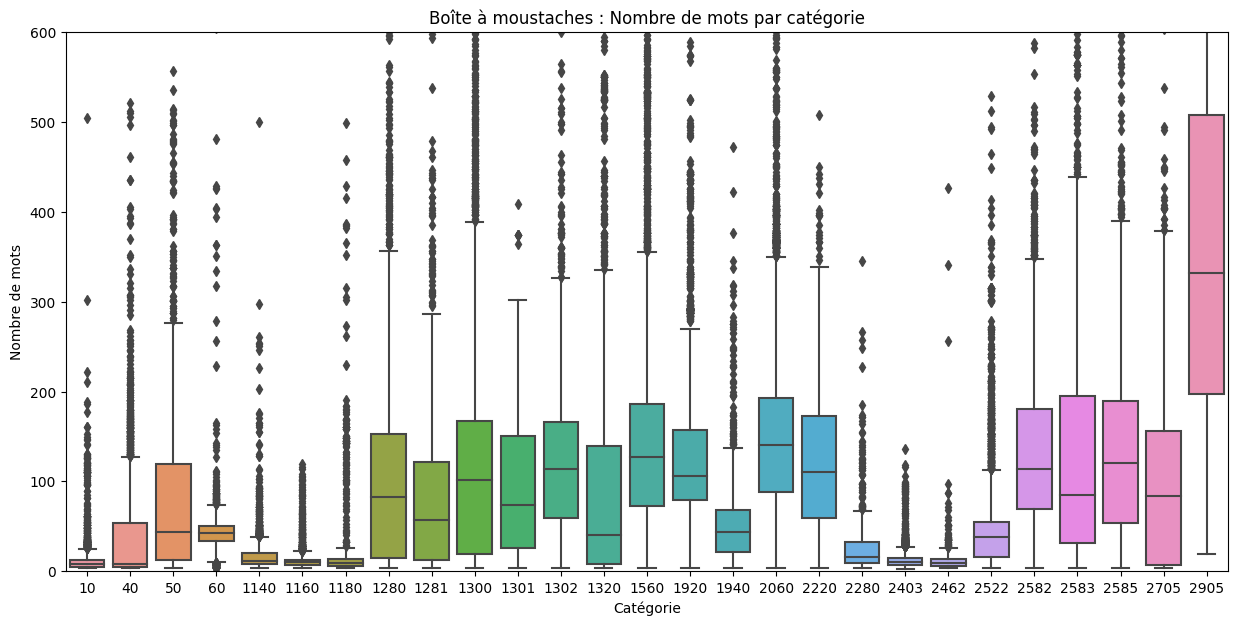

<Figure size 640x480 with 0 Axes>

In [32]:
#(15) Nombre de mots par catégorie

# Création du graphique en boîte avec Seaborn
plt.figure(figsize = (15 , 7))
sns.boxplot(data = df.sort_values(by='prdtypecode'), x = 'prdtypecode', y = 'nbmots_designation')
plt.ylim(0, 600)
plt.title("Boîte à moustaches : Nombre de mots par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de mots")
plt.show();

# Sauvegarde du graphique
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/photos_rapport/nombre_mots_par_categorie.png');

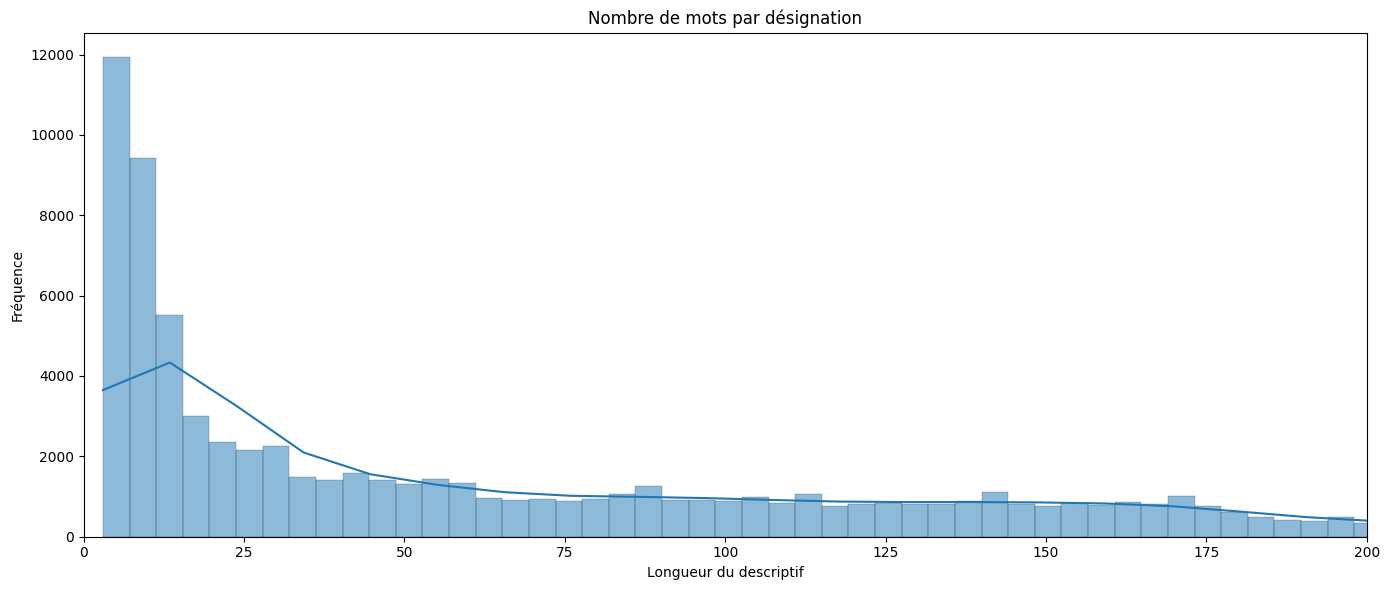

Histogramme - Nombre de mots par désignation


In [33]:
#(16) longueur du descriptif des produits
# Légende

plt.figure(figsize = (14 , 6))

# Affichage du graphique
sns.histplot(data = df, x = 'nbmots_designation', kde=True, bins = 500 , common_norm = False)
plt.title('Nombre de mots par désignation')
plt.xlabel('Longueur du descriptif')
plt.ylabel('Fréquence')
plt.xlim(0 , 200)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/photos_rapport/nombre_mots_designation.png')
plt.show()

print("Histogramme - Nombre de mots par désignation")

In [ ]:
#(17) Détection langues
# Effectuer la détection de la langue pour chaque colonne de texte et stocker la langue détectée
# dans une nouvelle colonne.
df['description_complete_languages'] = df['description_complete'].apply(lambda x : detect(str(x)))

count_languages = df['description_complete_languages'].value_counts(normalize = True).round(2)



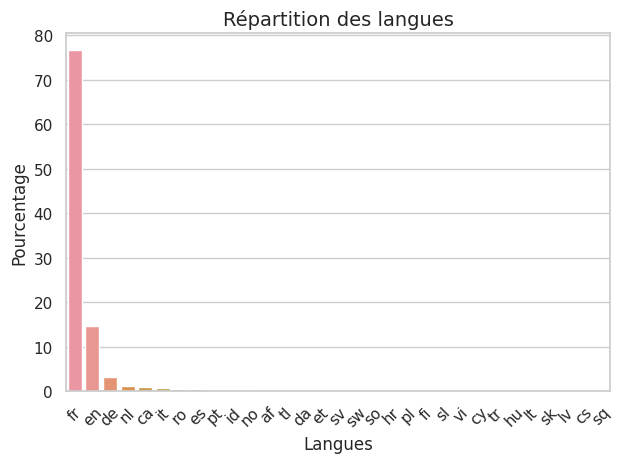

Répartition des langues


In [ ]:
#(18) Répartition des langues en %
# Calculer la répartition des langues en pourcentage
percentage_languages = (df['description_complete_languages'].value_counts() / len(df)) * 100

# Définir le style
sns.set(style = "whitegrid")

# Création d'un diagramme à barres
ax = sns.barplot(x = percentage_languages.index, y = percentage_languages)

# Ajouter des étiquettes et des titres
plt.xlabel('Langues' , fontsize = 12)
plt.ylabel('Pourcentage' , fontsize = 12)
plt.title('Répartition des langues', fontsize = 14)

# Rotation des étiquettes de l'axe x
plt.xticks(rotation = 45)

# Enregistrer le graphique
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/photos_rapport/language_distribution.png')

# Afficher le graphique
plt.show()

print("Répartition des langues")


In [ ]:
#(19) Création d'une fonction de prétraitement de texte
#Définition des stopwords pour le français et l'anglais
# Définition des stopwords pour le français et l'anglais
stopwords_fr = set(stopwords.words('french'))
stopwords_en = set(stopwords.words('english'))
stopwords_de = set(stopwords.words('german'))

# Fonction de prétraitement des textes
def preprocess_text(text):
    # Vérifier si le texte n'est pas null, NaN, ou float
    if isinstance(text, str):
        # Supprimer les balises HTML
        text = BeautifulSoup(text, "html.parser").get_text()

        # Supprimer les parenthèses et leur contenu
        text = re.sub(r'\([^)]*\)', '', text)

        # Supprimer les URLs
        text = re.sub(r'http\S+|www\S+', '', text)

        # Supprimer les adresses e-mail
        text = re.sub(r'\S+@\S+', '', text)

        # Supprimer la ponctuation
        text = re.sub(r'[^\w\s]', '', text)

        # Supprimer les unités de mesure
        text = re.sub(r'\b\w{1,2}\b', '', text)

        # Supprimer les unités de mesure
        text = re.sub(r'\b(cm|mm|kg|g|l|ml|oz|lb|in)\b', '', text)

        # Supprimer les dates
        text = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '', text)  # Supprimer les dates au format jj/mm/aaaa ou mm/jj/aaaa
        text = re.sub(r'\d{1,2}-\d{1,2}-\d{2,4}', '', text)  # Supprimer les dates au format jj-mm-aaaa ou jj-mm-aaaa
        text = re.sub(r'\d{1,2}\s+\w+\s+\d{2,4}', '', text)  # Supprimer les dates au format jj Mois aaaa ou Mois jj, aaaa

        # Enlever les chiffres
        text = re.sub(r'\d+', '', text)
        text = " ".join(text.split())
        # Convertir en minuscules
        text = text.lower()

        # Tokenisation des mots
        tokens = word_tokenize(text)

        # Suppression des stopwords
        tokens = [word for word in tokens if word.lower() not in stopwords_fr and word.lower() not in stopwords_en and word.lower() not in stopwords_de]

        # Stemming
        stemmer = SnowballStemmer('french')
        tokens = [stemmer.stem(word) for word in tokens]

        # Post-lemmatisation
        tagged_tokens = nltk.pos_tag(tokens)
        pos_words = [word for word, tag in tagged_tokens if tag.startswith('N') or tag.startswith('V') or tag.startswith('J') or tag.startswith('R')]

        # Reconstitution du texte prétraité
        preprocessed_text = ' '.join(tokens)

          # Vérifier si le texte prétraité est vide
        if not preprocessed_text:
          return 'a'  # Remplacer par la lettre 'a' si le texte prétraité est vide

        return preprocessed_text



In [ ]:
#(20) Prétraitement de la colonne description_complete
df['description_complete_prétraite'] = df['description_complete'].apply(preprocess_text)

# Remplacer les cellules vides par la lettre 'a' dans la colonne 'description_complete_prétraite'
#df['description_complete_prétraite'].fillna('a', inplace=True)
#df.to_csv('/content/drive/MyDrive/Rakuten.csv' , index=False)

<ipython-input-22-001fd295dc93>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


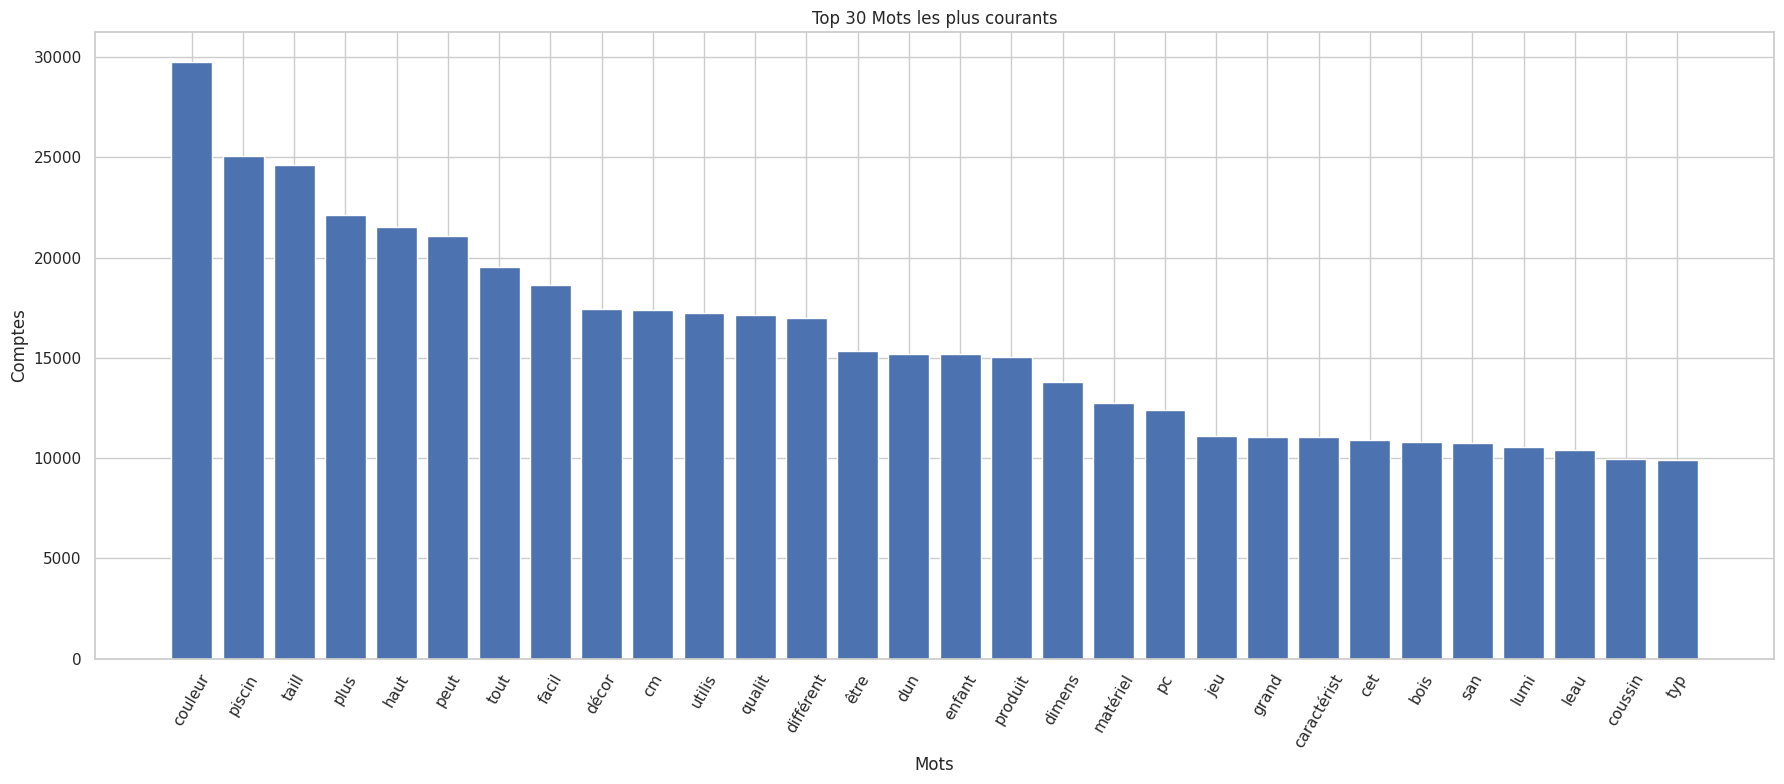

Top 30 Mots les plus courants


In [ ]:
#(21) Top 30 des mots les plus fréquents
# Comptage de mots
word_counts = Counter()
for doc in df['description_complete_prétraite']:
    word_counts.update(doc.split())

top_n = 30
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)
plt.figure(figsize = (18, 8))

# Affichage du graphique

plt.bar(words, counts)
plt.xlabel('Mots')
plt.ylabel('Comptes')
plt.title('Top {} Mots les plus courants'.format(top_n))
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/photos_rapport/top_words.png')
plt.show()

print("Top {} Mots les plus courants".format(top_n))

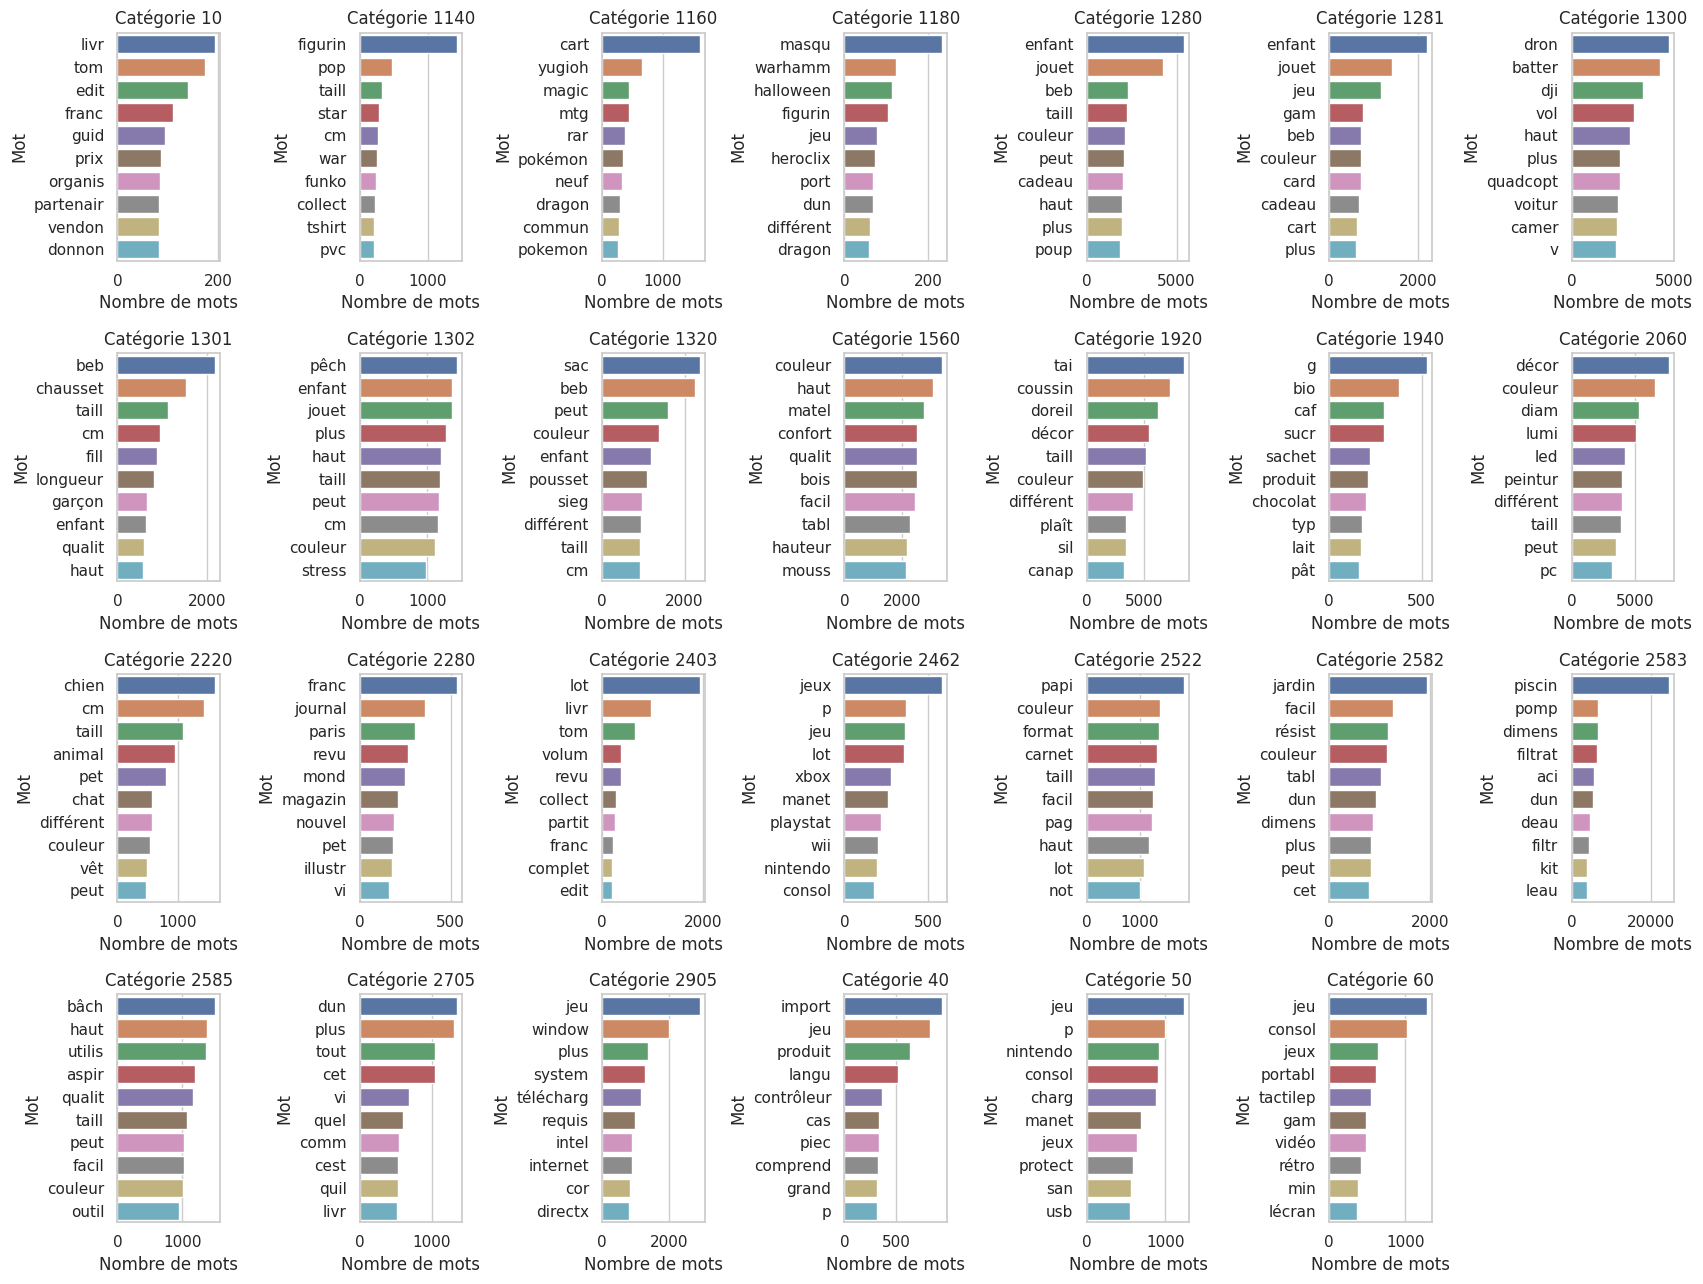

Mots les plus fréquents par catégorie


In [ ]:
#(22) Top 10 des mots les plus fréquents par catégorie
# Création d'une nouvelle colonne pour stocker les mots de la description
df['description_words'] = df['description_complete_prétraite'].str.split()

# Groupement par catégorie et comptage des mots
word_counts_by_category = df.groupby('prdtypecode')['description_words'].apply(lambda x : pd.Series(x).explode().value_counts())

# Transformation des données en un DataFrame
df_word_counts = word_counts_by_category.reset_index().rename(columns = {'level_1': 'word', 'description_words' : 'count'})

# Sélection des mots les plus fréquents pour chaque catégorie
top_words_by_category = df_word_counts.groupby('prdtypecode').head(10)

# Création des sous-graphiques pour chaque catégorie
fig, axes = plt.subplots(nrows = 4, ncols = 7, figsize = (17 , 13))

# Parcours des catégories et création des graphiques
for i, (category, ax) in enumerate(zip(top_words_by_category['prdtypecode'].unique(), axes.flatten())):
    data = top_words_by_category[top_words_by_category['prdtypecode'] == category]
    sns.barplot(data = data, x='count', y='word', ax = ax)
    ax.set_xlabel('Nombre de mots')
    ax.set_ylabel('Mot')
    ax.set_title(f'Catégorie {category}')

# Suppression des sous-graphiques inutilisés
for j in range(len(top_words_by_category['prdtypecode'].unique()) , len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

# Ajustement automatique des espacements entre les sous-graphiques
plt.tight_layout()

# Enregistrer le graphique
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/photos_rapport/top_words_by_category.png')

# Affichage du graphique
plt.show()

print("Mots les plus fréquents par catégorie")

# Analyse des images du data set

In [ ]:
#(23) détection d'images manquantes
# Ajout d'une colonne pour savoir si une image existe
df['img_found'] = df['img_pd'].isin(image_train['image_name'])
df.img_found.value_counts()

True    84916
Name: img_found, dtype: int64

In [ ]:
#(23b) Faire le lien entre image_train et df
# Ajout d'une colonne contenant le chemin vers les images
image_train['full_path'] = image_train.apply(lambda row :'/content/drive/MyDrive/' + row['folder_name'] + '/' + row['image_name'] , axis=1)

# renommer dans image_train le champ image_name en image_pd pour faire le merge entre df et image_train
image_train = image_train.rename(columns = {'image_name' : 'img_pd'})

# fusion de df et image_train pour récupérer les bordures des images
df = df.merge(image_train[['full_path', 'img_pd', 'folder_name']], on = 'img_pd')

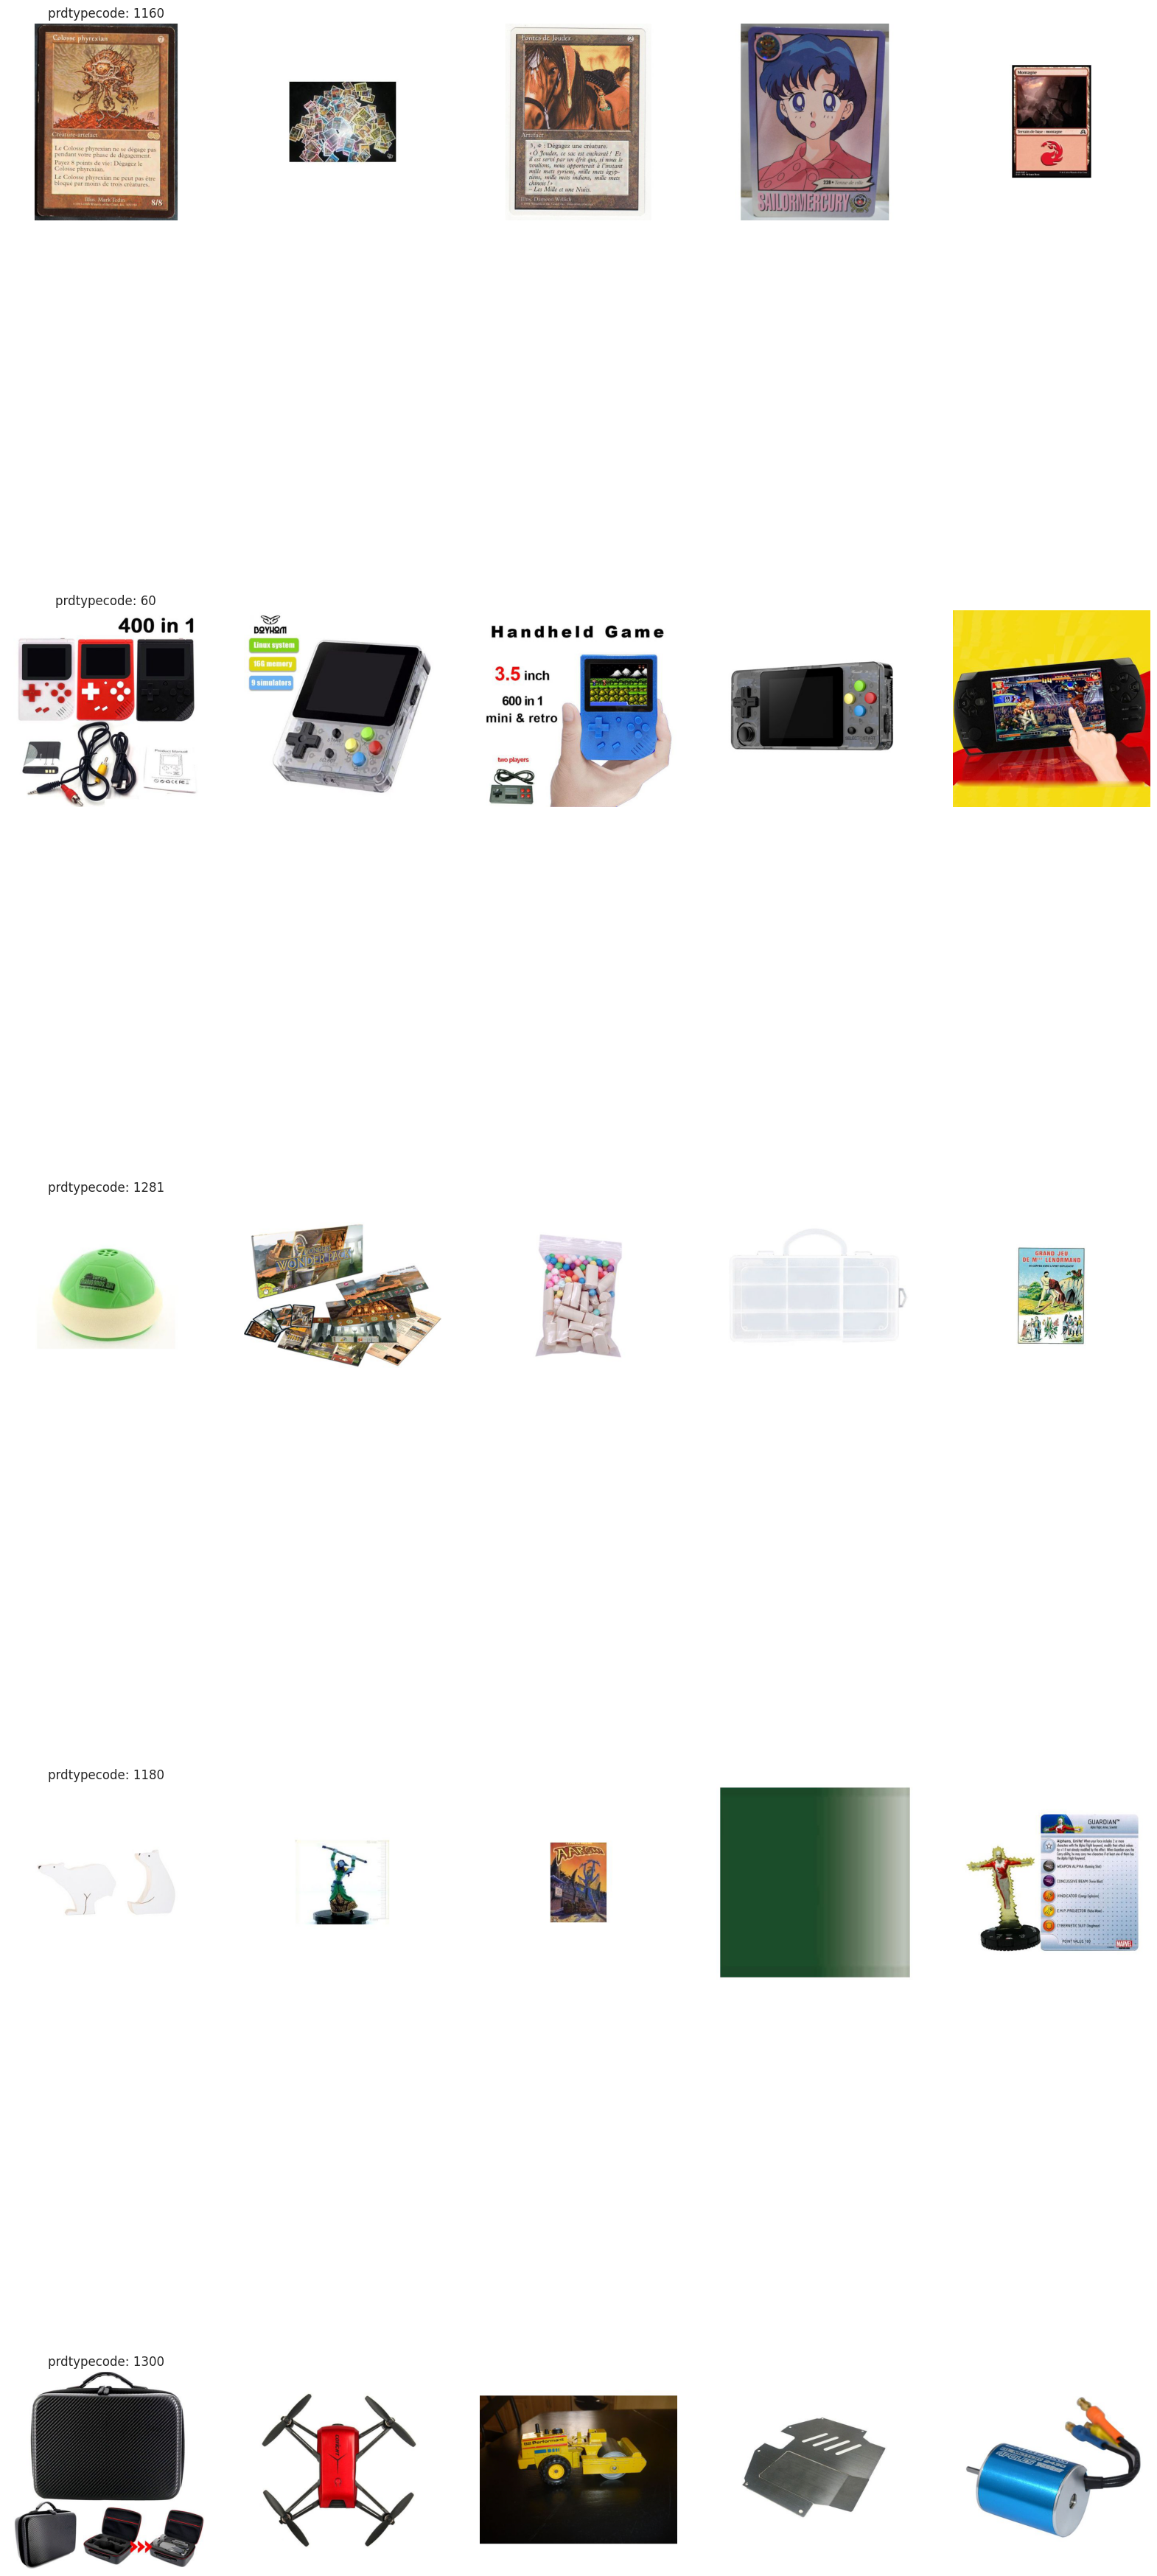

In [ ]:
#(24) affichage de 5 images aléatoires par catégorie (affichage limité à 5 catégories à la fois)
# Regroupement par catégorie de produits
grouped = df.groupby("prdtypecode")

# Obtention de 5 prdtypecodes
selected_prdtypes = df['prdtypecode'].unique()[5 : 10]

# Creation d'une figure et axes
fig, axes = plt.subplots(5, 5, figsize = (20 , 50))

# Itération sur les prdtypecodes sélectionnés
for i, prdtypecode in enumerate(selected_prdtypes):
    # group correspondant au prdtypecode
    group = grouped.get_group(prdtypecode)

    # Selection de 5 images aléatoires dans ce group
    selected_images = np.random.choice(group["full_path"], size = 5 , replace = False)

    # affichage des images
    for j , image_name in enumerate(selected_images):

        image = plt.imread(image_name)
        axes[i, j].imshow(image)
        axes[i, j].axis("off")

    # customisation du titre
    axes[i, 0].set_title(f"prdtypecode: {prdtypecode}")


### Code lancé en local

In [ ]:
#(25) méthode amplitude

#trouver les bordures horizontales et verticales "utiles" c-à-d:
#         l'amplitude du composant R d'une ligne ou colonne est inférieure à un seuil faible (100 par défaut) ET
#         l'amplitude du composant V d'une ligne ou colonne est  inférieure à un seuil faible (100 par défaut) ET
#         l'amplitude du composant B d'une ligne ou colonne est inférieure à un seuil faible (100 par défaut)

#on va balader un bâton de gauche à droite, de droite à gauche, de haut en bas et de bas en haut pour détecter la 1ère ligne ou colonne à amplitude>seuil
def trouve_perim_ampl(x, seuil = 100):
  col_gauche = 0
  col_droite = 0
  lig_bas = 0
  lig_haut = 0
  for col in range(500):
    amplitudes = [
        np.max(x[: , col, 0]) - np.min(x[: , col, 0]),
        np.max(x[: , col, 1]) - np.min(x[: , col, 1]),
        np.max(x[: , col, 2]) - np.min(x[: , col, 2])
    ]
    if np.sum(amplitudes) > seuil:
      col_gauche = col
      break

  for col in reversed(range(500)):
    amplitudes = [
        np.max(x[: , col, 0]) - np.min(x[: , col , 0]),
        np.max(x[: , col, 1]) - np.min(x[: , col , 1]),
        np.max(x[: , col, 2]) - np.min(x[: , col , 2])
    ]
    if np.sum(amplitudes) > seuil:
      col_droite = col
      break

  for lig in range(500) :
    amplitudes = [
        np.max(x[lig , : , 0]) - np.min(x[lig , : , 0]),
        np.max(x[lig , : , 1]) - np.min(x[lig , : , 1]),
        np.max(x[lig , : , 2]) - np.min(x[lig , : , 2])
    ]
    if np.sum(amplitudes) > seuil:
      lig_haut = lig
      break

  for lig in reversed(range(500)) :
    amplitudes = [
        np.max(x[lig,:,0]) - np.min(x[lig,:,0]),
        np.max(x[lig,:,1]) - np.min(x[lig,:,1]),
        np.max(x[lig,:,2]) - np.min(x[lig,:,2])
    ]
    if np.sum(amplitudes) > seuil:
      lig_bas = lig
      break

  specs_crop = np.array([[col_gauche , col_droite , lig_bas , lig_haut]])
  return specs_crop

In [ ]:
#(26) méthode variance

#trouver les bordures horizontales et verticales "utiles" c-à-d:
#         le composant R d'une ligne ou colonne est constant (variance nulle) ET
#         le composant V d'une ligne ou colonne est constant (variance nulle) ET
#         le composant B d'une ligne ou colonne est constant (variance nulle)

#on va balader un bâton de gauche à droite, de droite à gauche, de haut en bas et de bas en haut pour détecter la 1ère ligne ou colonne à var!=0
def trouve_perim_var(x, seuil = 0):
  col_gauche = 0
  col_droite = 0
  lig_bas = 0
  lig_haut = 0
  for col in range(500):
    if x[: , col , 0].var(axis=0)+x[: , col , 1].var(axis=0) + x[: , col , 2].var(axis = 0) > seuil :
      col_gauche = col
      break

  for col in reversed(range(500)) :
    if x[: , col , 0].var(axis=0) + x[: , col , 1].var(axis = 0) + x[: , col , 2].var(axis=0) > seuil :
      col_droite = col
      break

  for lig in range(500) :
    if x[lig , : , 0].var(axis = 0) + x[lig , : , 1].var(axis = 0) + x[lig , : , 2].var(axis = 0) > seuil :
        lig_haut = lig
        break

  for lig in reversed(range(500)) :
    if x[lig , : , 0].var(axis = 0) + x[lig , : ,1].var(axis = 0) + x[lig , : , 2].var(axis = 0) > seuil :
        lig_bas = lig
        break

  specs_crop = np.array([[col_gauche , col_droite , lig_bas , lig_haut]])
  return specs_crop


In [ ]:
#(27) Découpage du data set en 9 morceaux pour réduire le temps de calcul
image_train['full_path'] = image_train.apply(lambda row : '/content/drive/MyDrive/' + row['folder_name'] + '/' + row['img_pd'], axis = 1)

#subset=image_train.iloc[:10000]
#subset=image_train.iloc[10000:20000]
#subset=image_train.iloc[20000:30000]
#subset=image_train.iloc[30000:40000]
#subset=image_train.iloc[40000:50000]
#subset=image_train.iloc[50000:60000]
#subset=image_train.iloc[60000:70000]
#subset=image_train.iloc[70000:80000]
subset=image_train.iloc[80000:84916]


#on applique la fonction à chaque image du morceau
subset['lim_gauche'] = subset['full_path'].apply(lambda x : trouve_perim_ampl(plt.imread(x))[0 , 0])
subset['lim_droite'] = subset['full_path'].apply(lambda x : trouve_perim_ampl(plt.imread(x))[0 , 1])
subset['lim_bas'] = subset['full_path'].apply(lambda x : trouve_perim_ampl(plt.imread(x))[0 , 2])
subset['lim_haut'] = subset['full_path'].apply(lambda x : trouve_perim_ampl(plt.imread(x))[0 , 3])

<ipython-input-34-123397f0d8f3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['lim_gauche']=subset['full_path'].apply(lambda x:trouve_perim_ampl(plt.imread(x))[0,0])
<ipython-input-34-123397f0d8f3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['lim_droite']=subset['full_path'].apply(lambda x:trouve_perim_ampl(plt.imread(x))[0,1])
<ipython-input-34-123397f0d8f3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [ ]:
#(28) Export des morceaux et fusion
#export du morceau en csv
output_path = '/content/drive/MyDrive/subsets_ampl/sub9.csv'
subset.to_csv(output_path, index = True)

In [ ]:
#(29)fusion des morceaux
# Set the directory path where your CSV files are located in Google Drive
csv_directory = '/content/drive/MyDrive/subsets_ampl/'

# Get a list of all CSV files in the directory
csv_files = glob.glob(csv_directory + '*.csv')

# Création d'un data frame contenant du string et des entiers là où il faut afin de forcer pd.concat à respecter le type
merged_data = pd.DataFrame.from_dict({'image_name': ['zz'], 'folder_name': ['zz'] , 'prefix':['zz'], 'number':[1],'suffix' : ['zz'], 'full_path' : ['zz'], 'lim_gauche' : [1],'lim_droite' : [1], 'lim_bas' : [1], 'lim_haut' : [1]})

# Iterate over each CSV file
for file in csv_files :
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file, index_col = 0)

    # Append the data to the merged_data DataFrame
    merged_data = pd.concat([merged_data, data], axis = 0)

# Export the merged data to a CSV file in Google Drive
output_path = '/content/drive/MyDrive/merged_image_train_ampl.csv'
merged_data.to_csv(output_path, index=True)

### Suite des analyses

In [34]:
#(30) Import des données fusionnées
#import des échantillons fusionnés
image_train = pd.read_csv('/content/drive/MyDrive/merged_image_train_ampl.csv', index_col = 0, sep = ';')
image_train = image_train.rename(columns = {'image_name': 'img_pd'})

#suppression de la 1ère ligne contenant des zz et 1
image_train = image_train.iloc[1 :]
image_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84930
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   img_pd       84916 non-null  object
 1   folder_name  84916 non-null  object
 2   prefix       84916 non-null  object
 3   number       84916 non-null  int64 
 4   suffix       84916 non-null  object
 5   full_path    84916 non-null  object
 6   lim_gauche   84916 non-null  int64 
 7   lim_droite   84916 non-null  int64 
 8   lim_bas      84916 non-null  int64 
 9   lim_haut     84916 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 7.1+ MB


In [ ]:
#(31) test de différentes méthodes et seuils
subset = image_train.iloc[:500]

for seuil_teste in [5, 10, 100]:
  fichier_export = 'ampl_' + str(seuil_teste)
  #on applique la fonction à chaque image du morceau
  subset['lim_gauche'] = subset['full_path'].apply(lambda x : trouve_perim_ampl(plt.imread(x), seuil = seuil_teste)[0 , 0])
  subset['lim_droite'] = subset['full_path'].apply(lambda x : trouve_perim_ampl(plt.imread(x), seuil = seuil_teste)[0 , 1])
  subset['lim_bas'] = subset['full_path'].apply(lambda x : trouve_perim_ampl(plt.imread(x), seuil = seuil_teste)[0 , 2])
  subset['lim_haut'] = subset['full_path'].apply(lambda x : trouve_perim_ampl(plt.imread(x), seuil = seuil_teste)[0 , 3])

  #ajoute d'une colonne correspondant à la méthode utilisée
  subset['methode_testee'] = 'ampl'

  #ajoute d'une colonne correspondant au seuil testé
  subset['seuil_teste'] = seuil_teste

  #export du résultat
  output_path = '/content/drive/MyDrive/choix_seuil/' + fichier_export + '.csv'
  subset.to_csv(output_path, index = True)

<ipython-input-44-bff332051fa5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['lim_gauche']=subset['full_path'].apply(lambda x:trouve_perim_ampl(plt.imread(x),seuil=seuil_teste)[0,0])
<ipython-input-44-bff332051fa5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['lim_droite']=subset['full_path'].apply(lambda x:trouve_perim_ampl(plt.imread(x),seuil=seuil_teste)[0,1])
<ipython-input-44-bff332051fa5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [35]:
#(32) fusion df avec image_train enrichi
# fusion de df et image_train pour récupérer les bordures des images
df = df.merge(image_train[['img_pd', 'lim_gauche', 'lim_droite',
                           'lim_bas', 'lim_haut',]], on = 'img_pd')

#inverser haut et bas car Python commence à compter à partir du point le plus haut et le plus à gauche
df = df.rename(columns = {'lim_bas' : 'lim_haut', 'lim_haut' : 'lim_bas'})
df.head()

,designation,description,productid,imageid,prdtypecode,img_pd,description_complete,nbmots_designation,lim_gauche,lim_droite,lim_haut,lim_bas
0,Bien Enchérir En Attaque,,365202,67284,10,image_67284_product_365202.jpg,Bien Enchérir En Attaque,4,97,401,499,0
1,Toonstein : Le Château Hante,,184251,234234,40,image_234234_product_184251.jpg,Toonstein : Le Château Hante,5,14,484,489,10
2,Knock Out Kings 2000,,184752,234381,40,image_234381_product_184752.jpg,Knock Out Kings 2000,4,212,286,286,212
3,Mtv Music Generator 2,,853823,414480,40,image_414480_product_853823.jpg,Mtv Music Generator 2,4,77,421,499,0
4,Diablo Ii [Coffret Édition Limitée],,929166,482710,40,image_482710_product_929166.jpg,Diablo Ii [Coffret Édition Limitée],5,195,304,317,181


In [36]:
#(33) création des colonnes 'largeur', 'hauteur' et 'carré'
#délimitation de la largeur utile
df['largeur'] = df.apply(lambda row : 500-2*min(row['lim_gauche'], 499-row['lim_droite']), axis = 1)

#délimitation de la largeur utile
df['hauteur'] = df.apply(lambda row : 500-2*min(499-row['lim_haut'], row['lim_bas']), axis = 1)

#délimitation des dimensions optimales
df['carré'] = df.apply(lambda row : max(row['largeur'], row['hauteur']), axis = 1)

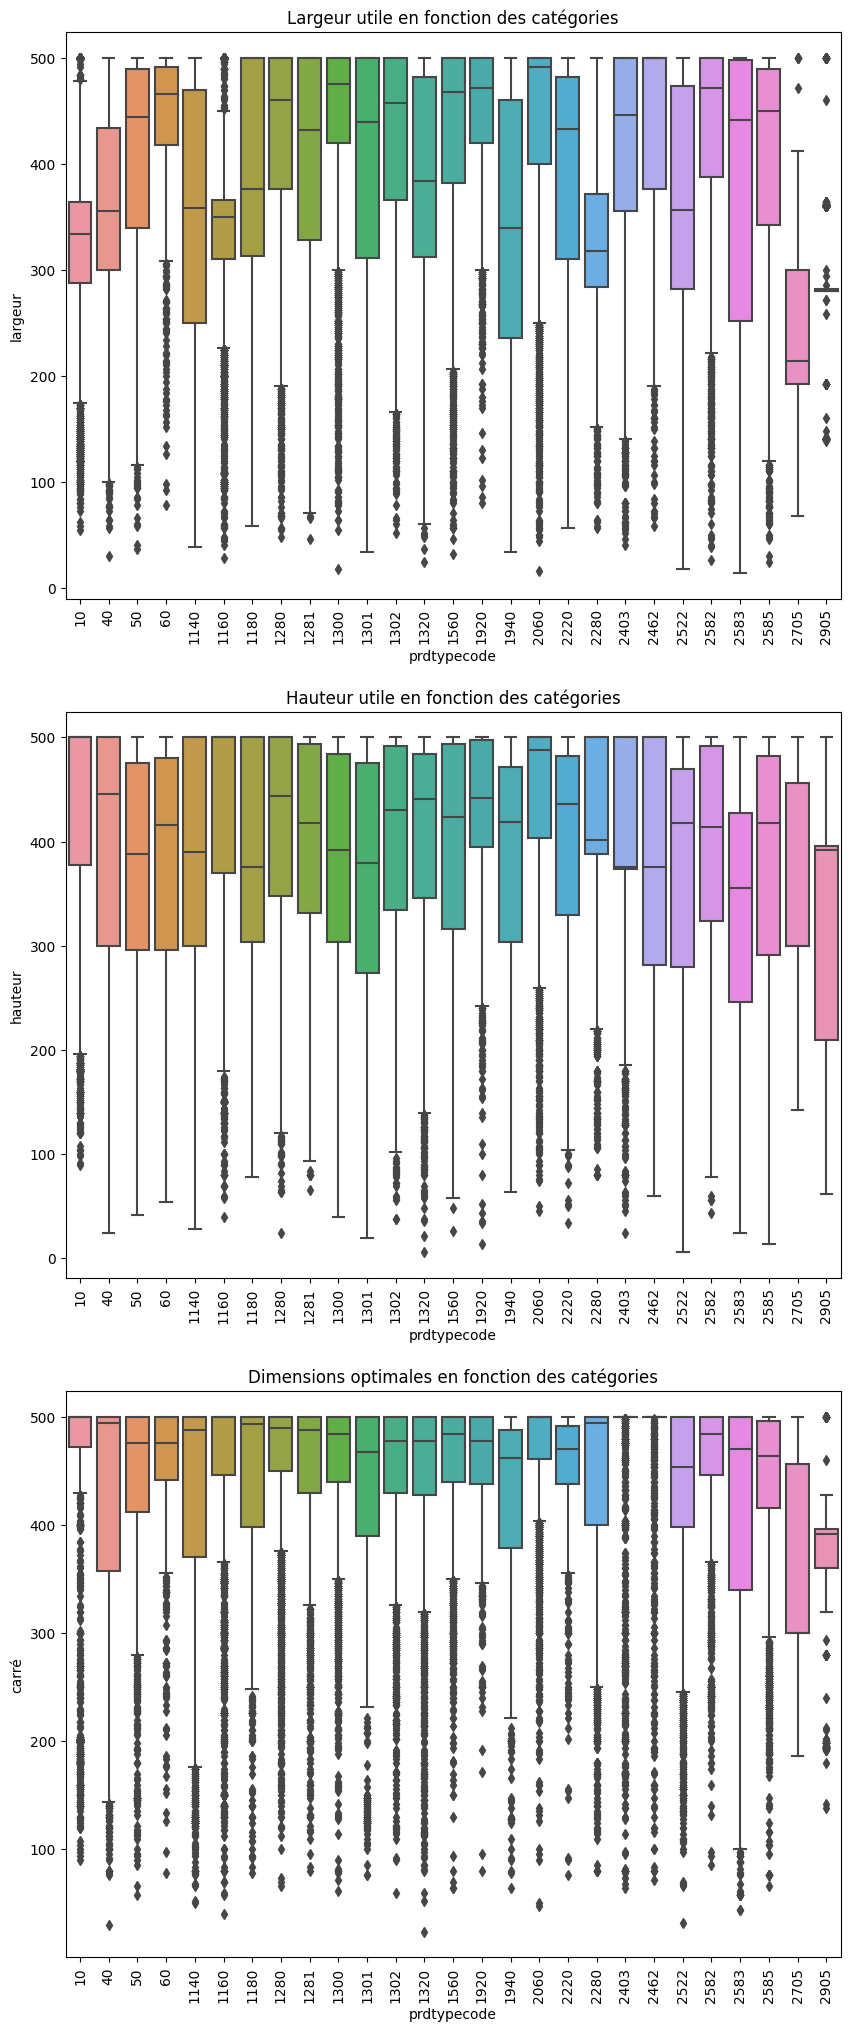

Box plots des dimensions par catégorie de produits


In [37]:
#(34) création de box plots par catégorie de produits
plt.figure(figsize = (10 , 25))

# Box plot largeur
plt.subplot(3, 1, 1)
sns.boxplot(data = df, x = 'prdtypecode', y = 'largeur')
plt.xticks(rotation = 90)
plt.title('Largeur utile en fonction des catégories')

# Box plot hauteur
plt.subplot(3, 1, 2)
sns.boxplot(data = df, x = 'prdtypecode', y = 'hauteur')
plt.xticks(rotation=90)
plt.title('Hauteur utile en fonction des catégories')

# Box plot carré (dimensions optimales)
plt.subplot(3, 1, 3)
sns.boxplot(data = df, x = 'prdtypecode', y = 'carré')
plt.xticks(rotation = 90)
plt.title('Dimensions optimales en fonction des catégories')

# Enregistrer le graphique
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/photos_rapport/boxplots_dimensions.png')

# Afficher le graphique
plt.show()

print("Box plots des dimensions par catégorie de produits")


### Code lancé en local

In [ ]:
#(35) Image moyenne

# Définir la plage valide pour les images RGB
plage_valide = (0 , 255)

# Calculer le nombre de valeurs prdtypecode uniques
num_unique = len(np.unique(df.prdtypecode))

# Calculer le nombre de rangées nécessaires
num_rows = (num_unique + 2) // 3

# Déterminer la taille de l'image
image_height = 480
image_width = 640

# Calculer la taille de la figure en fonction du nombre de rangées
figure_height = num_rows * image_height / 100
figure_width = image_width / 100 * 3

# Créer la figure avec la taille appropriée
fig, axes = plt.subplots(num_rows, 3, figsize = (figure_width, figure_height), squeeze = False)

# Aplatir les axes en une seule dimension pour faciliter l'itération
axes = axes.flatten()

# Parcourir les valeurs prdtypecode uniques
for i, ax in zip(np.unique(df.prdtypecode), axes):
    t = image_array[df['prdtypecode'] == i]
    img = t.mean(axis = 0)

    # Réduire les valeurs de l'image à la plage valide
    img = np.clip(img, plage_valide[0], plage_valide[1])

    # Mettre à l'échelle les valeurs de l'image dans la plage [0, 1]
    img = img / plage_valide[1]

    ax.imshow(img)
    ax.set_title(f"prdtypecode : {i}")
    ax.axis("off")

# Supprimer les axes inutilisés
for ax in axes[num_unique:]:
    ax.remove()

plt.tight_layout()
plt.show()

In [ ]:
(36) #Redimensionnement des images

# Chemin vers votre fichier zip contenant les images
zip_file_path = '/Users/flavien/Desktop/images/image_train.zip'

# Chemin du répertoire de sauvegarde des images augmentées
save_path = '/Users/flavien/Desktop/X_Train_image_traitement'

# Largeur et hauteur désirées pour les images redimensionnées
new_width = 299
new_height = 299

# Fonction pour charger et traiter les images d'un lot
def process_image_batch(zip_file , filenames):
    # Initialiser les listes pour stocker les images et les étiquettes
    images_batch = []

    # Boucle sur chaque fichier dans le lot
    for filename in filenames:
        # Vérifier si le fichier est une image valide
        image_type = imghdr.what(None, h = zip_file.read(filename))
        if image_type is not None:
            # Extraire le fichier d'image du zip
            img_file = zip_file.extract(filename)
            # Charger l'image
            img = Image.open(img_file)
            # Redimensionner l'image
            img_resized = img.resize((new_width, new_height))
            # Convertir l'image en tableau numpy
            img_array = np.array(img_resized)

            # Ajouter l'image au lot
            images_batch.append(img_array)

            # Sauvegarder l'image augmentée dans le répertoire de sauvegarde
            augmented_filename = f'augmented_{os.path.basename(filename)}'
            augmented_save_path = os.path.join(save_path, augmented_filename)
            img_resized.save(augmented_save_path)

            # Supprimer le fichier image extrait
            os.remove(img_file)
        else:
            print(f"Le fichier {filename} n'est pas une image valide. Ignoré.")

    # Convertir la liste en tableau numpy
    images_batch = np.array(images_batch)
    return images_batch

# Ouvrir le fichier zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Extraire les noms de fichiers du zip
    filenames = zip_file.namelist()
    # Trier les noms de fichiers par ordre croissant
    filenames.sort()

    # Définir le nombre total de photos et le nombre de lots souhaité
    total_photos = len(filenames)
    num_lots = 10  # Nombre de lots souhaité

    # Calculer la taille de chaque lot
    lot_size = total_photos // num_lots

    # Initialiser la liste pour stocker les lots d'images
    image_batches = []

    # Diviser les noms de fichiers en lots
    for i in range(0, total_photos, lot_size):
        batch_filenames = filenames[i:i + lot_size]

        # Traiter le lot d'images
        images_batch = process_image_batch(zip_file, batch_filenames)

        # Ajouter le lot d'images à la liste
        image_batches.append(images_batch)

# Concaténer les lots d'images en un seul tableau 4D
images = np.concatenate(image_batches, axis = 0)

# Afficher la forme du tableau d'images
print('Images shape:', images.shape)

#Concernant ce code, nous l'avons fait 2 fois entre X_TRAIN, X_TEST, en changent juste le chemin
# du fichier zip contenant les images et le chemin du répertoire de sauvegarde des images augmentées


In [ ]:
# (37) Traitement du bruit

# Chemin vers notre dossier contenant les images redimensionnées
input_directory = '/Users/flavien/Desktop/X_Train_image_traitement'

# Chemin du répertoire de sortie pour les images avec le bruit enlevé
output_directory = '/Users/flavien/Desktop/X_train_image_traitement_et_bruit_enlever'

# Taille du voisinage pour le filtre médian
neighborhood_size = 3

# Fonction pour appliquer le filtre médian à une image
def denoise_image(image):
    # Convertir l'image en tableau numpy
    img_array = np.array(image)

    # Appliquer le filtre médian
    img_denoised = median_filter(img_array, size=neighborhood_size)

    # Convertir l'image débruitée en image PIL
    img_denoised_pil = Image.fromarray(img_denoised)

    return img_denoised_pil

# Vérifier si le répertoire de sortie existe, sinon le créer
if not os.path.exists(output_directory) :
    os.makedirs(output_directory)

# Obtenir la liste de tous les fichiers dans le dossier et les trier par ordre croissant
filenames = sorted(os.listdir(input_directory))

# Boucle sur chaque fichier dans le dossier
for filename in filenames:
    # Vérifier si le fichier est une image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')) :
        # Charger l'image à partir du dossier
        img = Image.open(os.path.join(input_directory, filename))
        # Appliquer le débruitage à l'image
        img_denoised = denoise_image(img)
        # Définir le chemin de sortie de l'image débruitée
        output_filename = os.path.join(output_directory, os.path.splitext(os.path.basename(filename))[0]  + '.jpg')
        # Sauvegarder l'image débruitée en format JPEG
        img_denoised.save(output_filename)

# Afficher le chemin du répertoire de sortie contenant les images sans bruit
print('Chemin du répertoire de sortie contenant les images sans bruit :', output_directory)



In [ ]:
# (38) Affichier l'image entre origine et bruit enlevé
# Chargement des données des images
images_1 = np.load(file_path_1)
images_2 = np.load(file_path_2)

# Sélection de deux indices d'images à comparer (vous pouvez modifier ces indices selon vos besoins)
index_1 = 0
index_2 = 0

# Affichage des images d'origine
plt.subplot(1, 2, 1)
plt.imshow(images_1[index_1])
plt.title('Image d\'origine')

# Affichage des images avec bruit enlevé
plt.subplot(1, 2, 2)
plt.imshow(images_2[index_2])
plt.title('Image avec bruit enlevé')

# Affichage du comparatif
plt.tight_layout()
plt.show()


# Modèles ML pour le texte

## Modèles ML basiques

In [ ]:
# (39) Vectorisation
# Chargement des données
X = df['description_complete_prétraite']
y = df['prdtypecode']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Vectorisation
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [ ]:
# (40) Création d'une fonction pour extraire le score F1-score et le transformer en DataFrame
def extract_scores(report):
    # Séparer les lignes de la chaîne de caractères
    lines = report.strip().split('\n')

    # Extraire les noms de catégorie de chaque ligne
    categories = [line.split()[0] for line in lines[2:-4]]

    # Initialiser une liste pour les scores f1
    f1_scores = []

    # Parcourir les lignes et extraire les scores f1
    for line in lines[2:-4]:
        values = line.split()
        f1_scores.append(float(values[3]))

    # Créer un DataFrame à partir des scores f1
    df = pd.DataFrame({'Catégorie': categories, 'F1-score': f1_scores})

    return df


Exactitude du modèle : 0.77


<ipython-input-35-c2e0709ef975>:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  confusion_matrix_normalized_SVM_ = confusion_matrix_SVM_ / confusion_matrix_SVM_.sum(axis=1)[ : , np.newaxis]


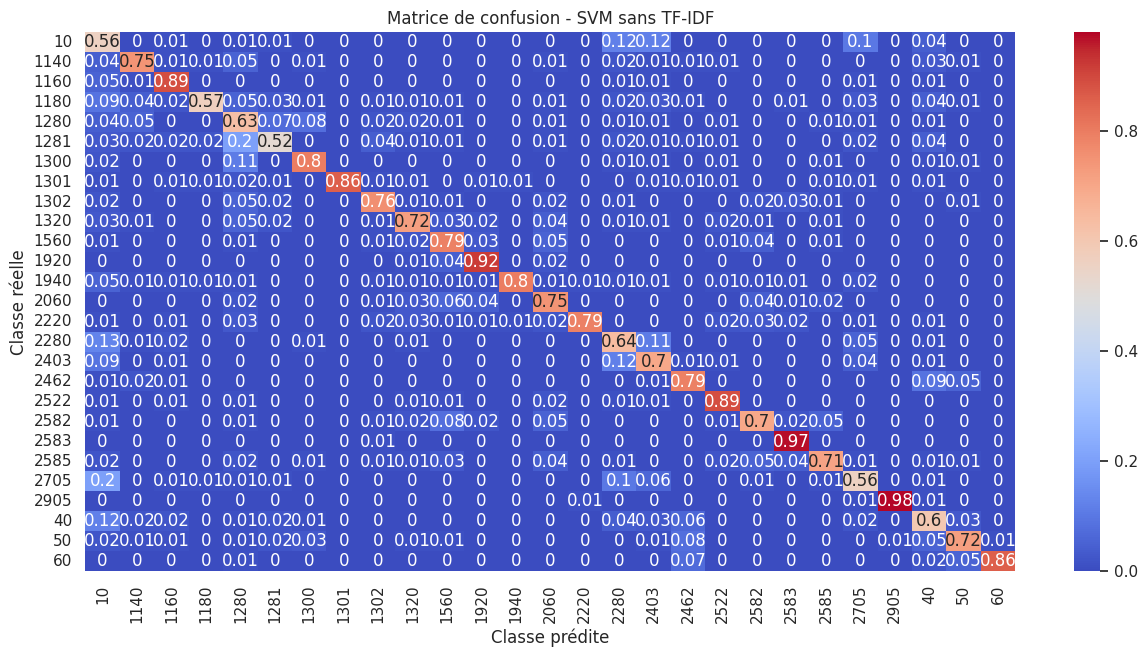

Rapport de classification SVM sans TF-IDF :
               precision    recall  f1-score   support

          10       0.35      0.56      0.43       605
        1140       0.76      0.75      0.76       521
        1160       0.88      0.89      0.89       794
        1180       0.68      0.57      0.62       159
        1280       0.62      0.63      0.62       977
        1281       0.63      0.52      0.57       438
        1300       0.87      0.80      0.84       996
        1301       0.93      0.86      0.89       162
        1302       0.79      0.76      0.77       506
        1320       0.77      0.72      0.75       661
        1560       0.79      0.79      0.79      1026
        1920       0.90      0.92      0.91       869
        1940       0.90      0.80      0.85       165
        2060       0.78      0.75      0.77      1008
        2220       0.83      0.79      0.81       170
        2280       0.65      0.64      0.64       969
        2403       0.69      0.70   

In [ ]:
# (41) Modèle SVM sans utilisation TF-IDF

svm = SVC(kernel = 'linear')

svm.fit(X_train_vect, y_train)

y_pred_svm_ = svm.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred_svm_)
print("Exactitude du modèle : {:.2f}".format(accuracy))

# Création de la matrice de confusion
confusion_matrix_SVM_ = pd.crosstab(y_test, y_pred_svm_, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

# Normalisation de la matrice de confusion
confusion_matrix_normalized_SVM_ = confusion_matrix_SVM_ / confusion_matrix_SVM_.sum(axis=1)[ : , np.newaxis]

# Arrondir les valeurs à deux chiffres après la virgule
confusion_matrix_normalized_SVM_ = np.round(confusion_matrix_normalized_SVM_, decimals = 2)

# Création du graphique heatmap avec les couleurs coolwarm
plt.figure(figsize=(15, 7))
sns.heatmap(confusion_matrix_normalized_SVM_, annot = True, cmap = 'coolwarm')
plt.title("Matrice de confusion - SVM sans TF-IDF")
plt.show()

# Calcul du rapport de classification
report_SVM_ = classification_report(y_test, y_pred_svm_)
print("Rapport de classification SVM sans TF-IDF :\n", report_SVM_)

In [ ]:
# (42) TF-IDF
# Créez une instance du vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Appliquez TF-IDF sur X_train
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Appliquez TF-IDF sur X_test en utilisant le même vectoriseur
X_test_tfidf = tfidf_vectorizer.transform(X_test)


Exactitude : 0.8054050871408385
Précision (macro) : 0.8202445967684623


<ipython-input-30-0967132d83ed>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  confusion_matrix_normalized_SVM_TFIDF = confusion_matrix_SVM / confusion_matrix_SVM.sum(axis=1)[:, np.newaxis]


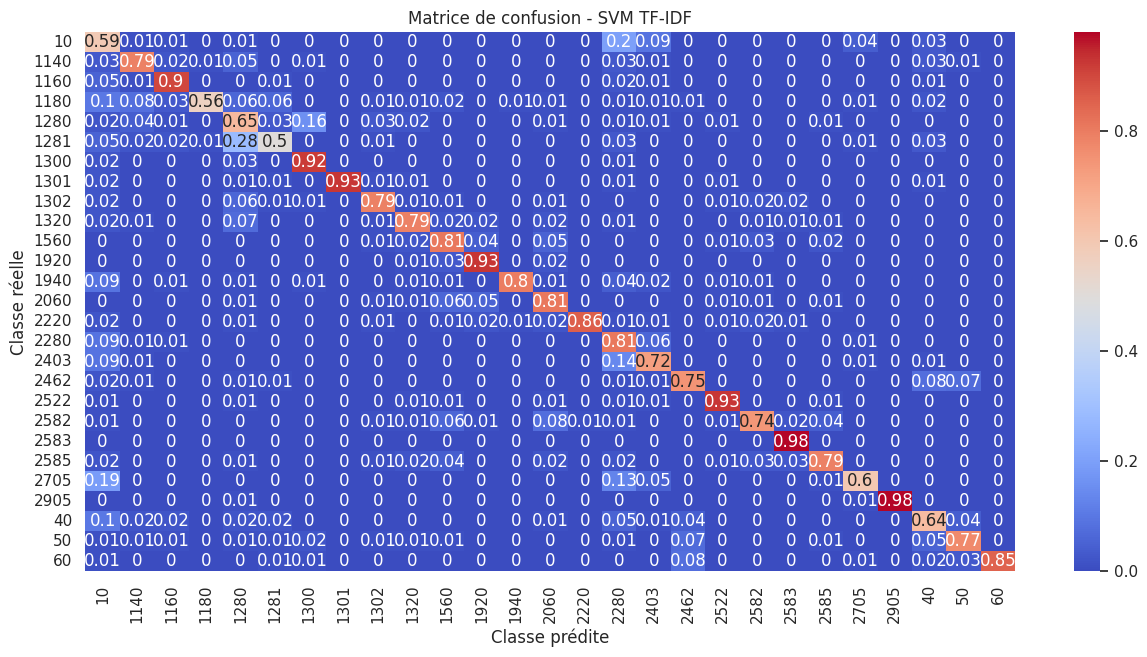

Rapport de classification SVM avec TF-IDF :
               precision    recall  f1-score   support

          10       0.41      0.59      0.49       654
        1140       0.78      0.79      0.78       516
        1160       0.91      0.90      0.90       769
        1180       0.85      0.56      0.68       156
        1280       0.66      0.65      0.65       999
        1281       0.71      0.50      0.58       426
        1300       0.83      0.92      0.88      1031
        1301       0.97      0.93      0.95       163
        1302       0.84      0.79      0.81       498
        1320       0.83      0.79      0.81       662
        1560       0.82      0.81      0.81      1013
        1920       0.88      0.93      0.90       871
        1940       0.90      0.80      0.85       164
        2060       0.81      0.81      0.81       987
        2220       0.90      0.86      0.88       160
        2280       0.62      0.81      0.70       925
        2403       0.77      0.72   

In [ ]:
# (43) SVM avec TF IDF
# Création d'un objet SVM avec un noyau linéaire
clf_svm = SVC(kernel = 'linear')

# Entraînement du SVM sur les données d'entraînement
clf_svm.fit(X_train_tfidf, y_train)

# Prédiction sur les données de test
y_pred_svm = clf_svm.predict(X_test_tfidf)

# Calcul de l'exactitude
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_svm)
print("Exactitude :", accuracy)

# Calcul de la précision (macro)
precision = precision_score(y_test, y_pred_svm, average = 'macro')
print("Précision (macro) :", precision)

# Création de la matrice de confusion
confusion_matrix_SVM = pd.crosstab(y_test, y_pred_svm, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

# Normalisation de la matrice de confusion
confusion_matrix_normalized_SVM_TFIDF = confusion_matrix_SVM / confusion_matrix_SVM.sum(axis=1)[ :, np.newaxis]

# Arrondir les valeurs à deux chiffres après la virgule
confusion_matrix_normalized_SVM_TFIDF = np.round(confusion_matrix_normalized_SVM_TFIDF, decimals = 2)

# Création du graphique heatmap avec les couleurs coolwarm
plt.figure(figsize=(15, 7))
sns.heatmap(confusion_matrix_normalized_SVM_TFIDF, annot = True, cmap = 'coolwarm')
plt.title("Matrice de confusion - SVM TF-IDF")
plt.show()

# Calcul du rapport de classification
report_SVM_TFIDF = classification_report(y_test, y_pred_svm)
print("Rapport de classification SVM avec TF-IDF :\n", report_SVM_TFIDF)

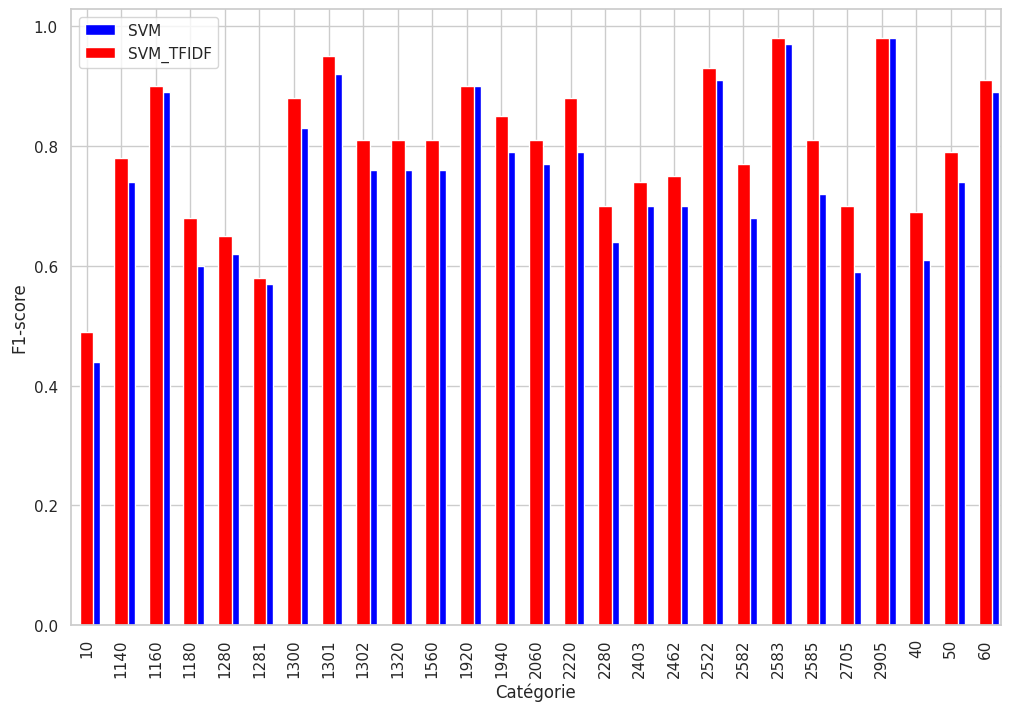

In [ ]:
# (44) Création des DataFrames des modèles de SVM
df_svm_tfidf = extract_scores(report_SVM_TFIDF)
df_svm = extract_scores(report_SVM_)

# Fusionner les DataFrames sur l'index
df_score_svm = pd.merge(df_svm, df_svm_tfidf, on = 'Catégorie', suffixes = ('_SVM', '_SVM_TFIDF'))


plt.figure(figsize = (12, 8))

# Mettre le nom des catégories en label X
df_score_svm.set_index('Catégorie', inplace = True)

# Créer un graphe en barre comparant les catégories selon la colonne 'f1-score'
df_score_svm['F1-score_SVM'].plot(kind = 'bar', color = 'blue', position = 0, width = 0.4, align = 'center')
df_score_svm['F1-score_SVM_TFIDF'].plot(kind = 'bar', color = 'red', position = 1, width = 0.4, align = 'edge')

# Ajouter des étiquettes d'axe et une légende
plt.xlabel('Catégorie')
plt.ylabel('F1-score')
plt.legend(['SVM', 'SVM_TFIDF'])

# Afficher le graphe
plt.show()

## Modèles ML avancés

In [ ]:
# (45) Random Forest sans TF-IDF
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Entraîner le modèle
random_forest.fit(X_train_vect, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_tree = random_forest.predict(X_test_vect)

# Évaluer les performances du modèle en utilisant l'exactitude
accuracy = accuracy_score(y_test, y_pred_tree)
print("Exactitude du modèle : {:.2f}".format(accuracy))

# Calcul du rapport de classification
report_RF_ = classification_report(y_test, y_pred_tree)
print("Rapport de classification Random Forest sans TF-IDF :\n", report_RF_)

Exactitude du modèle : 0.76
Rapport de classification Random Forest sans TF-IDF :
               precision    recall  f1-score   support

          10       0.39      0.49      0.43       654
        1140       0.75      0.73      0.74       516
        1160       0.87      0.89      0.88       769
        1180       0.76      0.56      0.64       156
        1280       0.67      0.60      0.63       999
        1281       0.69      0.46      0.55       426
        1300       0.81      0.88      0.84      1031
        1301       0.99      0.88      0.93       163
        1302       0.89      0.73      0.80       498
        1320       0.82      0.75      0.79       662
        1560       0.73      0.79      0.76      1013
        1920       0.91      0.90      0.91       871
        1940       0.90      0.73      0.81       164
        2060       0.75      0.81      0.78       987
        2220       0.94      0.64      0.76       160
        2280       0.61      0.68      0.64       92

In [ ]:
# (46) Random Forest avec TF-IDF
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Entraîner le modèle
random_forest.fit(X_train_tfidf, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_tree_TFIDF = random_forest.predict(X_test_tfidf)

# Évaluer les performances du modèle en utilisant l'exactitude
accuracy = accuracy_score(y_test, y_pred_tree_TFIDF)
print("Exactitude du modèle : {:.2f}".format(accuracy))

# Calcul du rapport de classification
report_RF_TFIDF = classification_report(y_test, y_pred_tree_TFIDF)
print("Rapport de classification Random Forest avec TF-IDF :\n", report_RF_TFIDF)

Exactitude du modèle : 0.77
Rapport de classification Random Forest avec TF-IDF :
               precision    recall  f1-score   support

          10       0.39      0.51      0.44       654
        1140       0.76      0.78      0.77       516
        1160       0.86      0.89      0.87       769
        1180       0.78      0.55      0.65       156
        1280       0.65      0.61      0.63       999
        1281       0.67      0.50      0.57       426
        1300       0.80      0.88      0.84      1031
        1301       0.98      0.88      0.93       163
        1302       0.88      0.72      0.79       498
        1320       0.81      0.74      0.77       662
        1560       0.74      0.80      0.77      1013
        1920       0.90      0.90      0.90       871
        1940       0.87      0.74      0.80       164
        2060       0.75      0.81      0.78       987
        2220       0.93      0.63      0.75       160
        2280       0.65      0.73      0.69       92

In [ ]:
# (47) Gradient Boosting sans TF-IDF
#GradientBoostingClassifier
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train_vect, y_train)

y_pred_gb = gradient_boosting.predict(X_test_vect)

accuracy_gb = accuracy_score(y_test, y_pred_gb)

print("Accuracy du GradientBoostingClassifier :", accuracy_gb)

# Calcul du rapport de classification
report_GB = classification_report(y_test, y_pred_gb)
print("Rapport de classification Random Forest avec TF-IDF :\n", report_GB)

Accuracy du GradientBoostingClassifier : 0.7265178729167894
Rapport de classification Random Forest avec TF-IDF :
               precision    recall  f1-score   support

          10       0.61      0.15      0.24       605
        1140       0.77      0.68      0.72       521
        1160       0.85      0.79      0.82       794
        1180       0.70      0.52      0.60       159
        1280       0.71      0.58      0.64       977
        1281       0.58      0.48      0.53       438
        1300       0.86      0.83      0.85       996
        1301       0.90      0.82      0.86       162
        1302       0.88      0.73      0.80       506
        1320       0.85      0.65      0.73       661
        1560       0.81      0.79      0.80      1026
        1920       0.88      0.91      0.90       869
        1940       0.90      0.69      0.78       165
        2060       0.77      0.78      0.78      1008
        2220       0.81      0.74      0.77       170
        2280       0

In [ ]:
# (48) Gradient Boosting avec TF-IDF
#GradientBoostingClassifier
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train_tfidf, y_train)

y_pred_gb_TFIDF = gradient_boosting.predict(X_test_tfidf)

# Calcul du rapport de classification
report_GB_TFIDF = classification_report(y_test, y_pred_gb_TFIDF)
print("Rapport de classification Gradient Boosting avec TF-IDF :\n", report_GB_TFIDF)

Rapport de classification Gradient Boosting avec TF-IDF :
               precision    recall  f1-score   support

          10       0.56      0.22      0.31       654
        1140       0.78      0.69      0.73       516
        1160       0.89      0.80      0.84       769
        1180       0.57      0.53      0.54       156
        1280       0.68      0.61      0.64       999
        1281       0.64      0.51      0.57       426
        1300       0.84      0.83      0.83      1031
        1301       0.88      0.90      0.89       163
        1302       0.89      0.75      0.81       498
        1320       0.82      0.68      0.75       662
        1560       0.76      0.77      0.77      1013
        1920       0.90      0.91      0.90       871
        1940       0.79      0.66      0.72       164
        2060       0.75      0.80      0.78       987
        2220       0.81      0.76      0.78       160
        2280       0.30      0.83      0.44       925
        2403       0.7

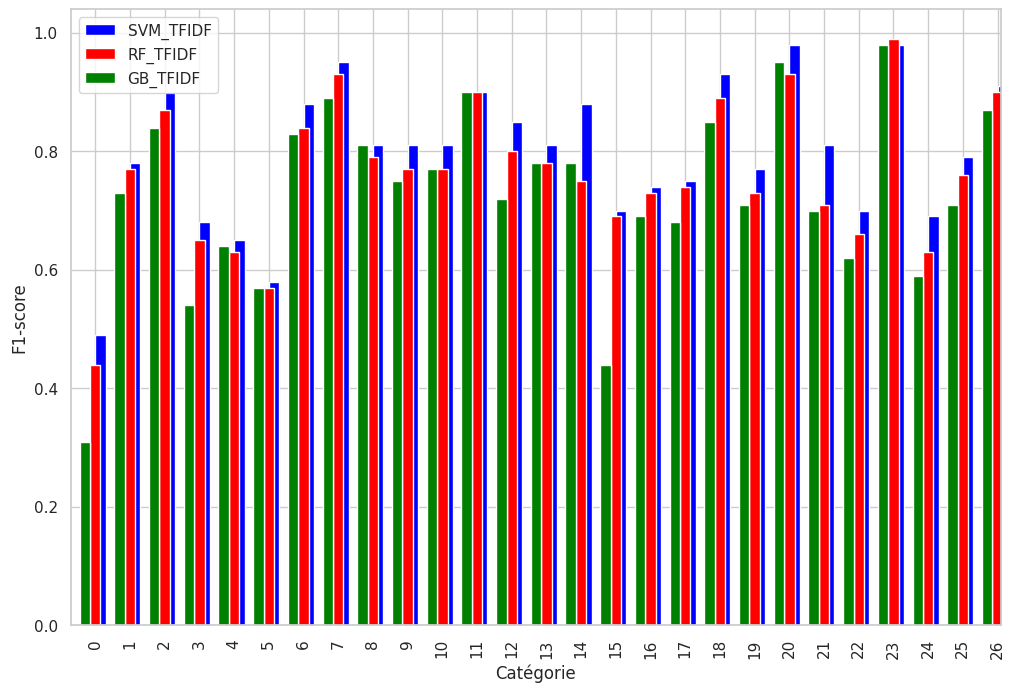

In [ ]:
# (49) Créer des DataFrames à partir des scores f1 des modèles random forest et gradientboosting avec TF-IDF
df_rf_tfidf = extract_scores(report_RF_TFIDF)
df_gb_tfidf = extract_scores(report_GB_TFIDF)

# Fusionner les DataFrames dans df_score
df_score = pd.merge(df_svm_tfidf, df_rf_tfidf, on = 'Catégorie', suffixes = ('_SVM_TFIDF', '_RF_TFIDF'))
df_score = pd.merge(df_score, df_gb_tfidf, on = 'Catégorie', suffixes = ('_SVM_TFIDF', '_RF_TFIDF','_GB_TFIDF'))
df_score.rename(columns = {'F1-score' : 'F1-score_GB_TFIDF'}, inplace = True)
df_score.head()

# création d'un graphe
plt.figure(figsize=(12, 8))

# Créer un graphe en barre comparant les catégories selon la colonne 'f1-score'
df_score['F1-score_SVM_TFIDF'].plot(kind = 'bar', color = 'blue', position = 0, width = 0.3, align = 'center')
df_score['F1-score_RF_TFIDF'].plot(kind = 'bar', color = 'red', position = 1, width = 0.3, align = 'edge')
df_score['F1-score_GB_TFIDF'].plot(kind = 'bar', color = 'green', position = 2, width = 0.3, align = 'edge')

# Ajouter des étiquettes d'axe et une légende
plt.xlabel('Catégorie')
plt.ylabel('F1-score')
plt.legend(['SVM_TFIDF', 'RF_TFIDF', 'GB_TFIDF'])

# Afficher le graphe
plt.show()

En résumé, le modèle de classification SVM obtient une performance globalement satisfaisante avec une exactitude de 0.804 et une précision macro de 0.819. Cependant, il convient de prendre en compte les performances spécifiques de chaque classe lors de l'analyse des résultats.

# Modèles ML pour images

In [ ]:
# (50) Création des tableaux 2D


import os
from PIL import Image
import numpy as np
from natsort import natsort_keygen

# Chemin vers le dossier contenant les images
input_directory = '/Users/flavien/Desktop/X_Train_image_traitement'

# Chemin où le tableau numpy 2D sera sauvegardé
output_path = '/Users/flavien/Desktop/2D_NUMPY_X_TRAIN/images_2D.npy'

# Obtenir la liste de tous les fichiers dans le dossier
filenames = os.listdir(input_directory)

nkey = natsort_keygen()

# Trier les noms de fichiers par ordre croissant
sorted_filenames = sorted(filenames, key = nkey)

# Initialiser une liste pour stocker les images triées
images_list = []

# Boucle sur chaque fichier dans le dossier
for filename in sorted_filenames :
    # Vérifier si le fichier est une image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Charger l'image à partir du dossier
        img = Image.open(os.path.join(input_directory, filename))
        # Convertir l'image en tableau numpy
        img_array = np.array(img)
        # Aplatir le tableau d'image en un vecteur 1D
        img_vector = img_array.flatten()
        # Ajouter le vecteur d'image à la liste
        images_list.append(img_vector)

# Convertir la liste de vecteurs d'images en tableau numpy 2D
images_2D = np.stack(images_list)

# Sauvegarder le tableau numpy 2D en tant que fichier numpy
np.save(output_path, images_2D)

# Afficher la forme du tableau d'images 2D
print('Images shape:', images_2D.shape)

#Concernant ce code, nous l'avons fait 2 fois entre X_TRAIN, X_TEST, en changent juste le chemin
# du fichier zip contenant les images et le chemin du répertoire de sauvegarde des images (Utiliser pour la régression logistique)

In [ ]:
# (51) Régression logistique

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(image_data, labels_image, test_size = 0.2, random_state = 42)

# Initialiser le classificateur de régression logistique avec le support partial_fit
classifier = SGDClassifier(loss = 'log_loss', alpha = 100, penalty = 'l2', max_iter = 1000, tol = 1e-3)

# Définir le nombre de plis ou de lots
num_folds = 20

# Déterminer la taille de chaque pli
fold_size = len(X_train) // num_folds

# Itérer sur les plis
for fold in range(num_folds):
    # Déterminer les indices de début et de fin pour le pli actuel
    start_idx = fold * fold_size
    end_idx = start_idx + fold_size if fold < num_folds - 1 else len(X_train)

    # Obtenir les données du pli actuel
    fold_X = X_train[start_idx:end_idx]
    fold_y = y_train[start_idx:end_idx]

    # Effectuer un ajustement partiel sur les données du pli actuel
    classifier.partial_fit(fold_X, fold_y, classes = np.unique(labels_image))

# Faire des prédictions sur l'ensemble de test
y_pred = classifier.predict(X_test)

# Calculer et afficher l'exactitude (accuracy) du classificateur
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy : .4f}")


In [ ]:
# (52) Prédiction aléatoire sans pondération en fonction de la fréquence respective des catégories

# catégories uniques
categories = np.unique(y_val)

# rapport de classification
random_predictions = np.random.choice(categories, size = 16984)
report_scenario1 = classification_report(y_val, random_predictions)
print("Scenario 1 - Random Predictions (without category weights):")
print(report_scenario1)

# performances
accuracy = accuracy_score(y_val, random_predictions)
precision = precision_score(y_val, random_predictions, average = 'macro')
score_f1 = f1_score(y_val, random_predictions, average = 'macro')

print("Scenario 1 - Random Predictions (No Category Weights)")
print(f"Accuracy: {accuracy : .2%}")
print(f"Precision:  {precision : .2%}")
print(f"F1 Score: {score_f1 : .2%}")

In [ ]:
# (53) Prédiction aléatoire avec pondération en fonction de la fréquence respective des catégories

# préparation de la pondération
category_counts = Counter(y_train)
total_count = sum(category_counts.values())
category_probabilities = [count / total_count for count in category_counts.values()]
categories = list(category_counts.keys())
random_weighted_predictions = np.random.choice(categories, size = 16984, p = category_probabilities)

# rapport de classification
report_scenario2 = classification_report(y_val, random_weighted_predictions)
print("Scenario 2 - Random Weighted Predictions (with category weights):")
print(report_scenario2)

# performances
accuracy = accuracy_score(y_val, random_weighted_predictions)
precision = precision_score(y_val, random_weighted_predictions, average = 'macro')
score_f1 = f1_score(y_val, random_weighted_predictions, average = 'macro')

print("Scenario 2 - Random Predictions (With Category Weights)")
print(f"Accuracy: {accuracy : .2%}")
print(f"Precision: {precision : .2%}")
print(f"F1 Score:  {score_f1 : .2%}")
print()

# Modèles Deep Learning pour le texte

In [ ]:
# (54) RNN - LSTM 128 neurones
# Prétraitement des données
x = df["description_complete_prétraite"]
y = df["prdtypecode"]
# Convertir les données en listes de chaînes de caractères
x = x.astype(str).tolist()
y = y.tolist()
# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.2, random_state = 42)

# Prétraitement et vectorisation des données textuelles avec TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Tri des indices de la matrice creuse
X_train_tfidf.sort_indices()
X_test_tfidf.sort_indices()

# Convertir les étiquettes en catégories d'entiers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convertir les catégories d'entiers en vecteurs encodés en one-hot
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

# Créer le modèle de réseau de neurones récurrents
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model.add(Dense(num_classes, activation='softmax'))

# Compiler le modèle
model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

# Entraîner le modèle
model.fit(X_train_tfidf, y_train_onehot, epochs = 10, batch_size = 32, validation_data = (X_test_tfidf, y_test_onehot))

# Évaluer le modèle sur les données de validation
_, accuracy = model.evaluate(X_test_tfidf, y_test_onehot)
print(f"Accuracy_{str(unit1)}_{str(couches)} : {accuracy * 100.0:.2f}%")

# Prédire les classes des données de validation
predictions = model.predict(X_test_tfidf)
predicted_labels = np.argmax(predictions, axis = 1)

y_val =np.argmax(y_test_onehot, axis = 1)

# Sauvegarder les prédictions dans un fichier CSV
results_df = pd.DataFrame({'True Label': y_test_onehot, 'Predicted Label': predicted_labels})
results_df.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/Text_RNN_LSTM/predictions_Text_RNN_LSTM_{str(combination_name)}.csv', index = False)

# Charger le DataFrame
df_path = "/Users/flavien/Desktop/projet_RAKUTEN/DF/sorted_df.csv"
df = pd.read_csv(df_path, index_col = 0)

liste_categories = np.unique(df.prdtypecode)
# Générer le rapport de classification
report = classification_report(y_test_onehot, predicted_labels, output_dict = True)
rapport_classification = pd.DataFrame(report).transpose()
rapport_classification.rename(index=dict(zip(rapport_classification.index[:27], liste_categories)), inplace = True)

# Enregistrer le DataFrame en format CSV
rapport_classification.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/Text_RNN_LSTM/rapport_Text_RNN_LSTM_{str(combination_name)}.csv', index=True)

# Obtenez les données d'historique
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']


# Tracez les courbes de perte
plt.plot(training_loss, label='Perte Entraînement')
plt.plot(validation_loss, label='Perte Validation')
plt.xlabel('epoch')
plt.ylabel('Perte')
plt.title('Perte d\'Entraînement et de Validation')
plt.legend()
plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/Text_RNN_LSTM/graphique_perte_Text_RNN_LSTM_{str(combination_name)}.png')
plt.show()

# Tracez les courbes de précision
plt.plot(training_accuracy, label='Précision Entraînement')
plt.plot(validation_accuracy, label='Précision Validation')
plt.xlabel('epoch')
plt.ylabel('Précision')
plt.title('Précision d\'Entraînement et de Validation')
plt.legend()
plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/Text_RNN_LSTM/graphique_precision_Text_RNN_LSTM_{str(combination_name)}.png')
plt.show()

# Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_test_onehot, predicted_labels)

# Normaliser la matrice de confusion et arrondir les valeurs à zéro décimale
totals = np.sum(cnf_matrix, axis=1)
normalized_matrix = np.round((cnf_matrix / totals[:, np.newaxis]) * 100, 0)

# Affichage de la matrice de confusion normalisée
plt.figure(figsize=(20, 10))
plt.imshow(normalized_matrix, interpolation='nearest', cmap = 'Greens')
plt.title("Matrice de confusion normalisée")
plt.colorbar()
tick_marks = np.arange(len(liste_categories))
plt.xticks(tick_marks, liste_categories, rotation = "vertical")
plt.yticks(tick_marks, liste_categories)

for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    value = normalized_matrix[i, j]
    plt.text(j, i, f"{int(value)}",
            horizontalalignment="center",
            color="white" if i == j else ("red" if value > 9 else "black"),
            fontweight='bold' if i == j else 'normal')

    plt.ylabel('Vrais labels')
    plt.xlabel('Catégories prédites')

# Sauvegarder la figure en tant que fichier image
plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/Text_RNN_LSTM/matrice_conf_norm_Text_RNN_LSTM_{str(combination_name)}.png')

plt.show()

# Conversion de la matrice de confusion en DataFrame Pandas
df_confusion = pd.DataFrame(normalized_matrix, index=liste_categories, columns=liste_categories)

# Enregistrement du DataFrame en CSV
df_confusion.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/Text_RNN_LSTM/matrice_conf_norm_Text_RNN_LSTM_{str(combination_name)}.csv')


In [ ]:
# (55)  RNN - LSTM 256 neurones
# Prétraitement des données
x = df["description_complete_prétraite"]
y = df["prdtypecode"]
# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.2, random_state = 42)
# Prétraitement des données d'entrée pour le modèle LSTM
vectorizer = tf.keras.layers.TextVectorization(output_sequence_length = MAX_SEQUENCE_LENGTH)
vectorizer.adapt(np.array(x_train.astype(str).values.flatten()))
x_train = vectorizer(np.array(x_train.astype(str).values.flatten()))
x_test = vectorizer(np.array(x_test.astype(str).values.flatten()))
# Convertir les étiquettes en catégories d'entiers
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)
# Créer le modèle LSTM
model = Sequential()
model.add(tf.keras.layers.Embedding(len(vectorizer.get_vocabulary()), 256, input_length = MAX_SEQUENCE_LENGTH))
model.add(LSTM(256))
model.add(Dense(num_classes, activation = 'softmax'))
# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# Définir EarlyStopping
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
# Entraîner le modèle avec EarlyStopping
model.fit(x_train, y_train_onehot, epochs = 10, batch_size = 32, validation_data = (x_test, y_test_onehot), callbacks = [early_stopping])
# Évaluer le modèle sur les données de validation
_, accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Accuracy: {accuracy * 100.0:.2f}%")
# Prédire les classes des données de validation
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis = 1)
# Sauvegarder les prédictions dans un fichier CSV sur le bureau
results_df = pd.DataFrame({'True Label': y_test, 'Predicted Label': predicted_labels})
results_df.to_csv('/Users/flavien/Desktop/predictions.csv', index = False)
# Charger le DataFrame
df_path = "/Users/flavien/Desktop/projet_RAKUTEN/DF/sorted_df.csv"
df = pd.read_csv(df_path, index_col=0)
liste_categories = np.unique(df.prdtypecode)
# Générer le rapport de classification
report = classification_report(y_test, predicted_labels, output_dict = True)
rapport_classification = pd.DataFrame(report).transpose()
rapport_classification.rename(index=dict(zip(rapport_classification.index[:27], liste_categories)), inplace = True)
# Enregistrer le DataFrame en format CSV sur le bureau
rapport_classification.to_csv('/Users/flavien/Desktop/rapport.csv', index = True)
# Obtenez les données d'historique
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']
# Tracez les courbes de perte
plt.plot(training_loss, label = 'Perte Entraînement')
plt.plot(validation_loss, label = 'Perte Validation')
plt.xlabel('epoch')
plt.ylabel('Perte')
plt.title('Perte d\'Entraînement et de Validation')
plt.legend()
plt.savefig('/Users/flavien/Desktop/graphique_perte.png')
plt.show()
# Tracez les courbes de précision
plt.plot(training_accuracy, label='Précision Entraînement')
plt.plot(validation_accuracy, label='Précision Validation')
plt.xlabel('epoch')
plt.ylabel('Précision')
plt.title('Précision d\'Entraînement et de Validation')
plt.legend()
plt.savefig('/Users/flavien/Desktop/graphique_precision.png')
plt.show()
# Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_test, predicted_labels)
# Normaliser la matrice de confusion et arrondir les valeurs à zéro décimale
totals = np.sum(cnf_matrix, axis=1)
normalized_matrix = np.round((cnf_matrix / totals[:, np.newaxis]) * 100, 0)
# Affichage de la matrice de confusion normalisée
plt.figure(figsize=(20, 10))
plt.imshow(normalized_matrix, interpolation = 'nearest', cmap = 'Greens')
plt.title("Matrice de confusion normalisée")
plt.colorbar()
tick_marks = np.arange(len(liste_categories))
plt.xticks(tick_marks, liste_categories, rotation = "vertical")
plt.yticks(tick_marks, liste_categories)
for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    value = normalized_matrix[i, j]
    plt.text(j, i, f"{int(value)}",
             horizontalalignment="center",
             color="white" if i == j else ("red" if value > 9 else "black"),
             fontweight='bold' if i == j else 'normal')
plt.ylabel('Vrais labels')
plt.xlabel('Catégories prédites')
# Sauvegarder la figure en tant que fichier image sur le bureau
plt.savefig('/Users/flavien/Desktop/matrice_conf_norm.png')
plt.show()
# Conversion de la matrice de confusion en DataFrame Pandas
df_confusion = pd.DataFrame(normalized_matrix, index=liste_categories, columns = liste_categories)
# Enregistrement du DataFrame en CSV sur le bureau
df_confusion.to_csv('/Users/flavien/Desktop/matrice_conf_norm.csv')

In [ ]:
# (56)  RNN - LSTM 512 neurones
# Prétraitement des données
x = df["description_complete_prétraite"]
y = df["prdtypecode"]
# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.2, random_state = 42)
# Prétraitement des données d'entrée pour le modèle LSTM
vectorizer = tf.keras.layers.TextVectorization(output_sequence_length = MAX_SEQUENCE_LENGTH)
vectorizer.adapt(np.array(x_train.astype(str).values.flatten()))
x_train = vectorizer(np.array(x_train.astype(str).values.flatten()))
x_test = vectorizer(np.array(x_test.astype(str).values.flatten()))
# Convertir les étiquettes en catégories d'entiers
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)
# Créer le modèle LSTM
model = Sequential()
model.add(tf.keras.layers.Embedding(len(vectorizer.get_vocabulary()), 512, input_length = MAX_SEQUENCE_LENGTH))
model.add(LSTM(512))
model.add(Dense(num_classes, activation = 'softmax'))
# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
# Définir EarlyStopping
early_stopping = EarlyStopping(patience = 3, restore_best_weights = True)
# Entraîner le modèle avec EarlyStopping
model.fit(x_train, y_train_onehot, epochs=10, batch_size = 32, validation_data = (x_test, y_test_onehot), callbacks = [early_stopping])
# Évaluer le modèle sur les données de validation
_, accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Accuracy: {accuracy * 100.0:.2f}%")
# Prédire les classes des données de validation
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis = 1)
# Sauvegarder les prédictions dans un fichier CSV sur le bureau
results_df = pd.DataFrame({'True Label': y_test, 'Predicted Label': predicted_labels})
results_df.to_csv('/Users/flavien/Desktop/predictions.csv', index = False)
# Charger le DataFrame
df_path = "/Users/flavien/Desktop/projet_RAKUTEN/DF/sorted_df.csv"
df = pd.read_csv(df_path, index_col = 0)
liste_categories = np.unique(df.prdtypecode)
# Générer le rapport de classification
report = classification_report(y_test, predicted_labels, output_dict = True)
rapport_classification = pd.DataFrame(report).transpose()
rapport_classification.rename(index=dict(zip(rapport_classification.index[:27], liste_categories)), inplace = True)
# Enregistrer le DataFrame en format CSV sur le bureau
rapport_classification.to_csv('/Users/flavien/Desktop/rapport.csv', index = True)
# Obtenez les données d'historique
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']
# Tracez les courbes de perte
plt.plot(training_loss, label = 'Perte Entraînement')
plt.plot(validation_loss, label = 'Perte Validation')
plt.xlabel('epoch')
plt.ylabel('Perte')
plt.title('Perte d\'Entraînement et de Validation')
plt.legend()
plt.savefig('/Users/flavien/Desktop/graphique_perte.png')
plt.show()
# Tracez les courbes de précision
plt.plot(training_accuracy, label = 'Précision Entraînement')
plt.plot(validation_accuracy, label = 'Précision Validation')
plt.xlabel('epoch')
plt.ylabel('Précision')
plt.title('Précision d\'Entraînement et de Validation')
plt.legend()
plt.savefig('/Users/flavien/Desktop/graphique_precision.png')
plt.show()
# Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_test, predicted_labels)
# Normaliser la matrice de confusion et arrondir les valeurs à zéro décimale
totals = np.sum(cnf_matrix, axis=1)
normalized_matrix = np.round((cnf_matrix / totals[:, np.newaxis]) * 100, 0)
# Affichage de la matrice de confusion normalisée
plt.figure(figsize=(20, 10))
plt.imshow(normalized_matrix, interpolation='nearest', cmap = 'Greens')
plt.title("Matrice de confusion normalisée")
plt.colorbar()
tick_marks = np.arange(len(liste_categories))
plt.xticks(tick_marks, liste_categories, rotation = "vertical")
plt.yticks(tick_marks, liste_categories)
for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    value = normalized_matrix[i, j]
    plt.text(j, i, f"{int(value)}",
             horizontalalignment="center",
             color="white" if i == j else ("red" if value > 9 else "black"),
             fontweight='bold' if i == j else 'normal')
plt.ylabel('Vrais labels')
plt.xlabel('Catégories prédites')
# Sauvegarder la figure en tant que fichier image sur le bureau
plt.savefig('/Users/flavien/Desktop/matrice_conf_norm.png')
plt.show()
# Conversion de la matrice de confusion en DataFrame Pandas
df_confusion = pd.DataFrame(normalized_matrix, index=liste_categories, columns=liste_categories)
# Enregistrement du DataFrame en CSV sur le bureau
df_confusion.to_csv('/Users/flavien/Desktop/matrice_conf_norm.csv')

In [ ]:
# (57)  Comparaison peformances modèles LSTM
# import des rapports LSTM
fichier1 = "/Users/michaeldevaux/Documents/Jupyter Notebook project/LSTM_128/rapport.csv"
fichier2 = "/Users/michaeldevaux/Documents/Jupyter Notebook project/LSTM_256/rapport.csv"
fichier3 = "/Users/michaeldevaux/Documents/Jupyter Notebook project/LSTM_512/rapport.csv"
df1_RNN_LSTM_128 = pd.read_csv(fichier1)
df2_RNN_LSTM_256 = pd.read_csv(fichier2)
df3_RNN_LSTM_512 = pd.read_csv(fichier3)

# Extraire les catégories et les scores de f1 à partir de chaque dataframe
categories_128 = df1_RNN_LSTM_128.iloc[:, 0]
f1_scores_128 = df1_RNN_LSTM_128['f1-score']

categories_256 = df2_RNN_LSTM_256.iloc[:, 0]
f1_scores_256 = df2_RNN_LSTM_256['f1-score']

categories_512 = df3_RNN_LSTM_512.iloc[:, 0]
f1_scores_512 = df3_RNN_LSTM_512['f1-score']

# Configurer la figure et l'axe des graphiques
fig, ax = plt.subplots(figsize=(16, 6))

# Définir la largeur des barres
bar_width = 0.2

# Définir les positions des barres sur l'axe x
bar_positions_128 = np.arange(len(categories_128))
bar_positions_256 = bar_positions_128 + bar_width
bar_positions_512 = bar_positions_256 + bar_width

# Tracer les barres pour chaque catégorie et f1-score
ax.bar(bar_positions_128, f1_scores_128, width=bar_width, label='RNN LSTM 128')
ax.bar(bar_positions_256, f1_scores_256, width=bar_width, label='RNN LSTM 256')
ax.bar(bar_positions_512, f1_scores_512, width=bar_width, label='RNN LSTM 512')

# Configurer les étiquettes des axes et le titre
ax.set_xlabel('Catégories')
ax.set_ylabel('f1-score')
ax.set_title('Comparaison des f1-scores pour différentes architectures RNN LSTM')

# Définir les positions des étiquettes des catégories sur l'axe x
category_positions = bar_positions_128 + bar_width / 2
plt.xticks(category_positions, categories_128, rotation=90)

# Afficher une légende
ax.legend()

# Afficher le graphique
plt.show()

In [ ]:
#(58) RNN - BERT 128 neurones
# Chargement du tokenizer BERT
tokenizer = None
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
except OSError as e:
    print("Erreur lors du chargement des fichiers du modèle BERT :", str(e))
    print("Veuillez vous assurer que les fichiers du modèle BERT sont téléchargés.")
if tokenizer:
    # Tokenisation des textes d'entraînement
    x_train_tokens = tokenizer.batch_encode_plus(
        x_train,
        truncation = True,
        padding = True,
        max_length = 256,
        return_tensors = 'tf'
    )
    x_train_input_ids = x_train_tokens['input_ids']
    x_train_attention_mask = x_train_tokens['attention_mask']
    # Tokenisation des textes de test
    x_test_tokens = tokenizer.batch_encode_plus(
        x_test,
        truncation = True,
        padding = True,
        max_length = 256,
        return_tensors = 'tf'
    )
x_test_input_ids = x_test_tokens['input_ids']
x_test_attention_mask = x_test_tokens['attention_mask']
# Création du modèle BERT
input_ids = Input(shape = (256,), dtype=tf.int32, name = "input_ids")
attention_mask = Input(shape = (256,), dtype=tf.int32, name = "attention_mask")
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
bert_outputs = bert_model(input_ids, attention_mask = attention_mask)
# Ajout de couches supplémentaires pour la classification
x = bert_outputs.pooler_output
x = Dropout(0.1)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.1)(x)
output = Dense(len(label_encoder.classes_), activation = 'softmax')(x)
model = Model(inputs=[input_ids, attention_mask], outputs = output)
# Compiler le modèle
optimizer = Adam(learning_rate = 2e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
# Ajouter EarlyStopping avec min_delta
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2, min_delta = 0, restore_best_weights = True)
# Entraînement du modèle avec EarlyStopping
history = model.fit(
    [x_train_input_ids, x_train_attention_mask],
    y_train,
    epochs = 10,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [early_stopping]
    )
# Évaluer le modèle sur les données de test
predictions = model.predict([x_test_input_ids, x_test_attention_mask])
predicted_labels = np.argmax(predictions, axis = 1)


In [ ]:
#(59) RNN - CAMEMBERT 128 neurones
# Prétraitement des données
x = df["description_complete_prétraite"]
y = df["prdtypecode"]
# Convertir les données en listes de chaînes de caractères
x = x.astype(str).tolist()
y = y.tolist()
# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.2, random_state = 42)
# Chargement du tokenizer CamemBERT
tokenizer = None
try:
    tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')
except OSError as e:
    print("Erreur lors du chargement des fichiers du modèle CamemBERT :", str(e))
    print("Veuillez vous assurer que les fichiers du modèle CamemBERT sont téléchargés.")
if tokenizer:
    # Tokenisation des textes d'entraînement
    x_train_tokens = tokenizer.batch_encode_plus(
        x_train,
        truncation = True,
        padding = True,
        max_length = 128,
        return_tensors = 'tf'
    )
    x_train_input_ids = x_train_tokens['input_ids']
    x_train_attention_mask = x_train_tokens['attention_mask']
    # Tokenisation des textes de test
    x_test_tokens = tokenizer.batch_encode_plus(
        x_test,
        truncation = True,
        padding = True,
        max_length = 128,
        return_tensors = 'tf'
    )
    x_test_input_ids = x_test_tokens['input_ids']
    x_test_attention_mask = x_test_tokens['attention_mask']
    # Création du modèle Camembert
    input_ids = Input(shape = (128,), dtype=tf.int32, name = "input_ids")
    attention_mask = Input(shape=(128,), dtype=tf.int32, name = "attention_mask")
    camembert_model = TFCamembertModel.from_pretrained('camembert-base')
    camembert_outputs = camembert_model(input_ids, attention_mask = attention_mask)
    # Ajout de couches supplémentaires pour la classification
    x = camembert_outputs.pooler_output
    x = Dropout(0.1)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(len(label_encoder.classes_), activation = 'softmax')(x)
    model = Model(inputs = [input_ids, attention_mask], outputs = output)
    # Compiler le modèle
    optimizer = Adam(learning_rate = 2e-5)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    # Ajouter EarlyStopping avec min_delta
    early_stopping = EarlyStopping(monito r= 'val_loss', patience = 2, min_delta = 0, restore_best_weights = True)
    # Entraînement du modèle avec EarlyStopping
    history = model.fit(
        [x_train_input_ids, x_train_attention_mask],
        y_train,
        epochs = 10,
        batch_size = 64,
        validation_split = 0.2,
        callbacks = [early_stopping]
    )
    # Évaluer le modèle sur les données de test
    predictions = model.predict([x_test_input_ids, x_test_attention_mask])
    predicted_labels = np.argmax(predictions, axis = 1)
    # Sauvegarder les prédictions dans un fichier CSV
    results_df = pd.DataFrame({'True Label': y_test, 'Predicted Label': predicted_labels})
    results_df.to_csv('predictions.csv', index = False)
    # Générer le rapport de classification
    report = classification_report(y_test, predicted_labels, output_dict = True)
    rapport_classification = pd.DataFrame(report).transpose()
    # Enregistrer le rapport de classification dans un fichier CSV
    rapport_classification.to_csv('rapport_classification.csv', index = True)
    # Calcul de la matrice de confusion
    cnf_matrix = confusion_matrix(y_test, predicted_labels)
    # Normaliser la matrice de confusion et arrondir les valeurs à zéro décimale
    totals = np.sum(cnf_matrix, axis = 1)
    normalized_matrix = np.round((cnf_matrix / totals[:, np.newaxis]) * 100, 0)
    # Affichage de la matrice de confusion normalisée
    plt.figure(figsize = (20 , 10))
    plt.imshow(normalized_matrix, interpolation = 'nearest', cmap = 'Greens')
    plt.title("Matrice de confusion normalisée")
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation = "vertical")
    plt.yticks(tick_marks, np.unique(y_test))
    for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
        value = normalized_matrix[i, j]
        plt.text(j, i, f"{int(value)}",
                 horizontalalignment = "center",
                 color="white" if i == j else ("red" if value > 9 else "black"),
                 fontweight='bold' if i == j else 'normal')
    plt.ylabel('Vrais labels')
    plt.xlabel('Catégories prédites')
    # Sauvegarder la figure en tant que fichier image
    plt.savefig('matrice_confusion_norm.png')
    plt.show()
    # Conversion de la matrice de confusion en DataFrame Pandas
    df_confusion = pd.DataFrame(normalized_matrix, index = np.unique(y_test), columns = np.unique(y_test))
    # Enregistrement du DataFrame de la matrice de confusion en CSV
    df_confusion.to_csv('matrice_confusion_TEXt_RNN_CamemBERT.csv')

    # matrice de confusion
    nouveaux_labels = ['10', '40', '50', '60', '1140', '1160', '1180', '1280', '1281', '1300',
                       '1301', '1302', '1320', '1560', '1920', '1940', '2060', '2220', '2280',
                       '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905']
    df_confusion.index = nouveaux_labels
    df_confusion.columns = nouveaux_labels
    plt.figure(figsize=(20, 6))
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cmap='coolwarm')
    plt.xlabel('Prédiction')
    plt.ylabel('Véritable Label')
    plt.title('Matrice de confusion normalisée RNN modèle CAMEM_BERT 128')
    plt.show()

In [ ]:
#(60) RNN - CAMEMBERT 256 neurones
# Prétraitement des données
x = df["description_complete_prétraite"]
y = df["prdtypecode"]
# Convertir les données en listes de chaînes de caractères
x = x.astype(str).tolist()
y = y.tolist()
# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.2, random_state = 42)
# Chargement du tokenizer CamemBERT
tokenizer = None
try:
    tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')
except OSError as e:
    print("Erreur lors du chargement des fichiers du modèle CamemBERT :", str(e))
    print("Veuillez vous assurer que les fichiers du modèle CamemBERT sont téléchargés.")
if tokenizer:
    # Tokenisation des textes d'entraînement
    x_train_tokens = tokenizer.batch_encode_plus(
        x_train,
        truncation = True,
        padding = True,
        max_length = 256,
        return_tensors = 'tf'
    )
    x_train_input_ids = x_train_tokens['input_ids']
    x_train_attention_mask = x_train_tokens['attention_mask']
    # Tokenisation des textes de test
    x_test_tokens = tokenizer.batch_encode_plus(
        x_test,
        truncation = True,
        padding = True,
        max_length = 256,
        return_tensors = 'tf'
    )
    x_test_input_ids = x_test_tokens['input_ids']
    x_test_attention_mask = x_test_tokens['attention_mask']
    # Création du modèle Camembert
    input_ids = Input(shape = (256,), dtype = tf.int32, name = "input_ids")
    attention_mask = Input(shape = (256,), dtype=tf.int32, name = "attention_mask")
    camembert_model = TFCamembertModel.from_pretrained('camembert-base')
    camembert_outputs = camembert_model(input_ids, attention_mask=attention_mask)
    # Ajout de couches supplémentaires pour la classification
    x = camembert_outputs.pooler_output
    x = Dropout(0.1)(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(len(label_encoder.classes_), activation = 'softmax')(x)
    model = Model(inputs = [input_ids, attention_mask], outputs = output)
    # Compiler le modèle
    optimizer = Adam(learning_rate=2e-5)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    # Ajouter EarlyStopping avec min_delta
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2, min_delta = 0, restore_best_weights = True)
    # Entraînement du modèle avec EarlyStopping
    history = model.fit(
        [x_train_input_ids, x_train_attention_mask],
        y_train,
        epochs = 10,
        batch_size = 64,
        validation_split = 0.2,
        callbacks = [early_stopping]
    )
    # Évaluer le modèle sur les données de test
    predictions = model.predict([x_test_input_ids, x_test_attention_mask])
    predicted_labels = np.argmax(predictions, axis = 1)
    # Sauvegarder les prédictions dans un fichier CSV
    results_df = pd.DataFrame({'True Label': y_test, 'Predicted Label': predicted_labels})
    results_df.to_csv('predictions.csv', index=False)
    # Générer le rapport de classification
    report = classification_report(y_test, predicted_labels, output_dict = True)
    rapport_classification = pd.DataFrame(report).transpose()
    # Enregistrer le rapport de classification dans un fichier CSV
    rapport_classification.to_csv('rapport_classification.csv', index = True)
    # Calcul de la matrice de confusion
    cnf_matrix = confusion_matrix(y_test, predicted_labels)
    # Normaliser la matrice de confusion et arrondir les valeurs à zéro décimale
    totals = np.sum(cnf_matrix, axis=1)
    normalized_matrix = np.round((cnf_matrix / totals[:, np.newaxis]) * 100, 0)
    # Affichage de la matrice de confusion normalisée
    plt.figure(figsize = (20, 10))
    plt.imshow(normalized_matrix, interpolation='nearest', cmap = 'Greens')
    plt.title("Matrice de confusion normalisée")
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation="vertical")
    plt.yticks(tick_marks, np.unique(y_test))
    for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
        value = normalized_matrix[i, j]
        plt.text(j, i, f"{int(value)}",
                 horizontalalignment="center",
                 color="white" if i == j else ("red" if value > 9 else "black"),
                 fontweight='bold' if i == j else 'normal')
    plt.ylabel('Vrais labels')
    plt.xlabel('Catégories prédites')
    # Sauvegarder la figure en tant que fichier image
    plt.savefig('matrice_confusion_norm.png')
    plt.show()
    # Conversion de la matrice de confusion en DataFrame Pandas
    df_confusion = pd.DataFrame(normalized_matrix, index=np.unique(y_test), columns=np.unique(y_test))
    # Enregistrement du DataFrame de la matrice de confusion en CSV
    df_confusion.to_csv('matrice_confusion_TEXt_RNN_CamemBERT.csv')

In [ ]:
# (61) fonctions pour regroupement de catégories
def renommage(x):
  ### cette fonction prend en entrée un data frame et remplace les catégories
  ### et les index par des valeurs moins granulaires ce qui nous permettra par la
  ### suite de les regrouper à un niveau supérieur
    x['True Label'] = x['True Label'].astype(str)
    x['Predicted Label'] = x['Predicted Label'].astype(str)
    old_name=[str(element) for element in range(27)]
    nouveaux_labels = ['10', '40', '50', '60', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905']
    x=x.replace(to_replace=old_name, value=nouveaux_labels)
    old_name=['10','2280','2705','2403']
    new_name='Livres_magazines'
    x=x.replace(to_replace=old_name, value=new_name)

    old_name=['1140','1160','1180']
    new_name='Collections'
    x=x.replace(to_replace=old_name, value=new_name)

    old_name=['40','2905','50','60','1300','2462']
    new_name='Jeux_vidéos'
    x=x.replace(to_replace=old_name, value=new_name)

    old_name=['1280','1281','1320','1301','1302']
    new_name='Jeux_enf'
    x=x.replace(to_replace=old_name, value=new_name)

    old_name=['1560','1920','2060']
    new_name='Mobilier_int'
    x=x.replace(to_replace=old_name, value=new_name)

    old_name=['2582','2583','2585']
    new_name='Mobilier_ext'
    x=x.replace(to_replace=old_name, value=new_name)

    old_name=['1940']
    new_name='Alimentation'
    x=x.replace(to_replace=old_name, value=new_name)

    old_name=['2220']
    new_name='Animaux'
    x=x.replace(to_replace=old_name, value=new_name)

    old_name=['2522']
    new_name='Papeterie'
    x=x.replace(to_replace=old_name, value=new_name)
    return x

def plot_mat_conf(mat_crosstab):
  ### cette fonction prend en entrée une matrice de confusion au format crosstab
  ### et la transforme en une matrice normalisée et applique des couleurs distinctives
  ### surlignant les bonnes prédictions
    normalized_cross_raw = mat_crosstab.div(mat_crosstab.sum(axis=1), axis=0)
    normalized_matrix = normalized_cross_raw.to_numpy(dtype=float)
    plt.figure(figsize=(10, 5))
    plt.imshow(normalized_matrix, interpolation='nearest', cmap='Greens')
    plt.title("Matrice de confusion normalisée")
    plt.colorbar()

    tick_marks = np.arange(len(normalized_cross_raw.index))
    plt.xticks(tick_marks, normalized_cross_raw.columns, rotation="vertical")
    plt.yticks(tick_marks, normalized_cross_raw.index)

    for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
        value = normalized_matrix[i, j]
        plt.text(j, i, f"{100*value:.0f}",
                horizontalalignment="center",
                color="white" if i == j else ("red" if value > 9 else "black"),
                fontweight='bold' if i == j else 'normal')
    plt.ylabel('Vrais labels')
    plt.xlabel('Thématiques prédites')
    plt.show()
    return

In [ ]:
# (62) regroupement des catégories voisines et matrices de confusion normalisées
# import des prédictions
pred=pd.read_csv('/Users/chadiboulos/Downloads/predictions_bert_cam_128.csv')
pred=renommage(pred)

# matrices de confusion et rapport de classification
y_true=pred['True Label']
y_pred=pred['Predicted Label']
confusion=confusion_matrix(y_true, y_pred, labels=list(pred['True Label'].unique()))
report=classification_report(y_true,y_pred)
cross=pd.crosstab(y_true, y_pred, rownames=['réel'], colnames=['prédit'])

# affichage matrice normalisée
plot_mat_conf(cross)

# Modèles Deep Learning pour les images

In [ ]:
#(63) Resnet 50 avec multiples combinaisons de paramètres

# Charger les données d'entraînement
X_path = "/Users/flavien/Desktop/224_X_Train_4D/224_X_Train_4D.npy"
X_train = np.load(X_path)

# Charger le DataFrame
df_path = "/Users/flavien/Desktop/projet_RAKUTEN/DF/sorted_df.csv"
df = pd.read_csv(df_path)

# Prétraitement de la colonne "prdtypecode"
label_encoder = LabelEncoder()
df['prdtypecode'] = label_encoder.fit_transform(df['prdtypecode'])

# Prétraitement des données
y = df["prdtypecode"].values
y = to_categorical(y)  # Convertir les étiquettes en vecteurs one-hot
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size = 0.2, random_state = 42)

param_dense = [64,128,256,512]
param_couches = ['oui','non']
# Générer toutes les combinaisons possibles
parameter_combinations = list(itertools.product(param_dense,param_couches))
# Liste des combinaisons déjà réalisées
combinaisons_realisees = [
   (64, 'oui'),(64, 'non'),(128,'oui'), (128, 'non'),(256, 'non'), (512, 'non')
    # Ajoutez les autres combinaisons déjà réalisées ici
]

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


for combination in parameter_combinations:
    unit1, couches = combination
    combination_name = f"{unit1}_{couches}"
    if combination in combinaisons_realisees:
        print(f"Combinaison déjà réalisée : {combination_name}")
        continue
    print(f"Combinaison en cours : {combination_name}")

    # Création du modèle ResNet-50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

    # Ajout des couches supplémentaires
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if couches == 'oui':
        x = Dense(unit1, activation = "relu")(x)
        predictions = Dense(27, activation = "softmax")(x)
    else:
        predictions = Dense(27, activation = "softmax")(x)

    model = Model(inputs = base_model.input, outputs = predictions)

    # Geler les poids du modèle de base
    for layer in base_model.layers:
        layer.trainable = False

    # Compiler le modèle
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    # Entraînement du modèle avec augmentation de données
    batch_size = 32
    steps_per_epoch = len(X_train) // batch_size

    history = model.fit(
        X_train, y_train,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        validation_data = (X_val, y_val),
        epochs = 5
    )

    # Sauvegarde du modèle
    model.save(f"/Users/flavien/Desktop/projet_RAKUTEN/CNN_ResNet_sans_distortion/resnet_ss_augment_{str(combination_name)}.h5")


    # Évaluer le modèle sur les données de validation
    _, accuracy = model.evaluate(X_val, y_val)
    print(f"Accuracy_{str(unit1)}_{str(couches)} : {accuracy * 100.0:.2f}%")

    # Prédire les classes des données de validation
    predictions = model.predict(X_val)
    predicted_labels = np.argmax(predictions, axis = 1)

    y_val =np.argmax(y_val,axis = 1)

    # Sauvegarder les prédictions dans un fichier CSV
    results_df = pd.DataFrame({'True Label': y_val, 'Predicted Label': predicted_labels})
    results_df.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_ResNet_sans_distortion/predictions_resnet_ss_augm_{str(combination_name)}.csv', index=False)

    # Charger le DataFrame
    df_path = "/Users/flavien/Desktop/projet_RAKUTEN/DF/sorted_df.csv"
    df = pd.read_csv(df_path, index_col = 0)

    liste_categories = np.unique(df.prdtypecode)
    # Générer le rapport de classification
    report = classification_report(y_val, predicted_labels, output_dict = True)
    rapport_classification = pd.DataFrame(report).transpose()
    rapport_classification.rename(index=dict(zip(rapport_classification.index[:27], liste_categories)), inplace = True)

    # Enregistrer le DataFrame en format CSV
    rapport_classification.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_ResNet_sans_distortion/rapport_classif_resnet_ss_augment_{str(combination_name)}.csv', index=True)

    # Obtenez les données d'historique
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']


    # Tracez les courbes de perte
    plt.plot(training_loss, label = 'Perte Entraînement')
    plt.plot(validation_loss, label = 'Perte Validation')
    plt.xlabel('epoch')
    plt.ylabel('Perte')
    plt.title('Perte d\'Entraînement et de Validation')
    plt.legend()
    plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_ResNet_sans_distortion/graphique_perte_resnet_ss_augment_{str(combination_name)}.png')
    plt.show()

    # Tracez les courbes de précision
    plt.plot(training_accuracy, label = 'Précision Entraînement')
    plt.plot(validation_accuracy, label = 'Précision Validation')
    plt.xlabel('epoch')
    plt.ylabel('Précision')
    plt.title('Précision d\'Entraînement et de Validation')
    plt.legend()
    plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_ResNet_sans_distortion/graphique_precision_resnet_ss_augment_{str(combination_name)}.png')
    plt.show()

    # Calcul de la matrice de confusion
    cnf_matrix = confusion_matrix(y_val, predicted_labels)

    # Normaliser la matrice de confusion et arrondir les valeurs à zéro décimale
    totals = np.sum(cnf_matrix, axis=1)
    normalized_matrix = np.round((cnf_matrix / totals[:, np.newaxis]) * 100, 0)

    # Affichage de la matrice de confusion normalisée
    plt.figure(figsize=(20, 10))
    plt.imshow(normalized_matrix, interpolation='nearest', cmap = 'Greens')
    plt.title("Matrice de confusion normalisée")
    plt.colorbar()
    tick_marks = np.arange(len(liste_categories))
    plt.xticks(tick_marks, liste_categories, rotation = "vertical")
    plt.yticks(tick_marks, liste_categories)

    for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
        value = normalized_matrix[i, j]
        plt.text(j, i, f"{int(value)}",
                 horizontalalignment="center",
                 color="white" if i == j else ("red" if value > 9 else "black"),
                 fontweight='bold' if i == j else 'normal')

    plt.ylabel('Vrais labels')
    plt.xlabel('Catégories prédites')

    # Sauvegarder la figure en tant que fichier image
    plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_ResNet_sans_distortion/matrice_conf_norm_resnet_ss_augment_{str(combination_name)}.png')

    plt.show()



   # Conversion de la matrice de confusion en DataFrame Pandas
    df_confusion = pd.DataFrame(normalized_matrix, index=liste_categories, columns=liste_categories)

    # Enregistrement du DataFrame en CSV
    df_confusion.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_ResNet_sans_distortion/matrice_conf_norm_resnet_ss_augment_{str(combination_name)}.csv')




In [ ]:
#(64) Comparaison des performances des 3 réseaux de neurones
# Chemin du dossier contenant les fichiers CSV
chemin_dossier = '/Users/flavien/Desktop/projet_RAKUTEN/CNN_ResNet_sans_distortion/rapport_classif_resnet'

# Liste pour stocker les DataFrames de chaque fichier CSV
df_liste = []

# Parcourir tous les fichiers CSV dans le dossier
for fichier in os.listdir(chemin_dossier):
    if fichier.endswith('.csv'):
        chemin_fichier = os.path.join(chemin_dossier, fichier)
        categorie = fichier.split('.')[0]  # Extraire le nom de catégorie à partir du nom du fichier
        df = pd.read_csv(chemin_fichier)
        df['modèle'] = categorie  # Ajouter la colonne 'Categorie' au DataFrame
        df_liste.append(df)

# Concaténer tous les DataFrames en un seul DataFrame
df_Rapport_Resnet_ss_aug_mean = pd.concat(df_liste, ignore_index = True)

# Renommer la colonne 'Unnamed: 0' en 'Catégorie'
df_Rapport_Resnet_ss_aug_mean = df_Rapport_Resnet_ss_aug_mean.rename(columns={'Unnamed: 0' : 'famille'})

# Créer un masque booléen pour filtrer les lignes contenant les valeurs à supprimer
mask = df_Rapport_Resnet_ss_aug_mean['famille'].isin(['accuracy', 'macro avg', 'weighted avg'])

# Supprimer les lignes correspondantes du DataFrame
df_Rapport_Resnet_ss_aug_mean = df_Rapport_Resnet_ss_aug_mean[~mask]

# Affichage
df_Rapport_Resnet_ss_aug_mean.head(30)

#Ceci est réalisé pour tous les modèles et sera regroupé dans un df pour réaliser le graphique avec les courbes


#(63)
# Création du graphique en barres
plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1_scores, color = colors)
plt.xlabel('Modèle')
plt.ylabel('F1-score')
plt.xticks(rotation=90)
plt.title('Moyenne des scores F1 par modèle - Resnet sans augmentation')

# Ajout des pourcentages au milieu des barres
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = f1_scores[i] * 100  # Conversion en pourcentage
    plt.text(bar.get_x() + bar.get_width() / 2, height/2, f'{percentage:.2f}%', ha = 'center', va = 'center')

# Ajout de la moyenne en tant que ligne pointillée noire
mean_f1_score = df_mean_f1_score.mean()
line = plt.axhline(y = mean_f1_score, color = 'black', linestyle = 'dashed')

# Ajout du pourcentage personnalisé à côté de la ligne pointillée
custom_percentage = 51.31  # Votre pourcentage personnalisé ici
plt.text(len(models) - 0.00, mean_f1_score, f'{custom_percentage :.2f}%', ha = 'right', va = 'bottom')

# Ajout de la légende pour la ligne pointillée en bas à droite
plt.legend([line], ['Moyenne'], loc = 'lower right', bbox_to_anchor = (1, 0))

plt.show()

In [ ]:
# (65) Comparaison des performances des différentes combinaisons pour Resnet 50 sans augmentation

# Liste des chemins des fichiers CSV
chemins_fichiers = [
    '/Users/flavien/Desktop/projet_RAKUTEN/CNN_DF_RESEM_PR_ANALY/df_Rapport_Lenet_mean.csv',
    '/Users/flavien/Desktop/projet_RAKUTEN/CNN_DF_RESEM_PR_ANALY/df_Rapport_Mobilnet_ss_aug_mean.csv',
    '/Users/flavien/Desktop/projet_RAKUTEN/CNN_DF_RESEM_PR_ANALY/df_Rapport_Resnet_av_aug_mean.csv',
    '/Users/flavien/Desktop/projet_RAKUTEN/CNN_DF_RESEM_PR_ANALY/df_Rapport_Resnet_ss_aug_mean.csv'
]

# Liste pour stocker les DataFrames
df_list = []

# Lire chaque fichier CSV et l'ajouter à la liste des DataFrames
for chemin in chemins_fichiers:
    df = pd.read_csv(chemin)
    df_list.append(df)

# Concaténer tous les DataFrames en un seul DataFrame
df_total = pd.concat(df_list, ignore_index = True)

df_total[df_total['famille'] == 10]
# Graphique Moyenne F1 score - Tout modèles confondues

# Calcul des moyennes des scores F1 par modèle
df_total_agg = df_total.groupby(['nom_modèles']).agg({'f1-score' : 'mean'})

# Données des modèles et des scores F1
models = df_total_agg.index.tolist()
f1_scores = df_total_agg['f1-score']

# Index du modèle ayant le score le plus bas et le score le plus élevé
lowest_index = f1_scores.idxmin()
highest_index = f1_scores.idxmax()

# Liste des couleurs pour les barres
colors = ['red' if i == lowest_index else 'green' if i == highest_index else 'blue' for i in models]

# Création du graphique en barres
plt.figure(figsize = (10, 6))
bars = plt.bar(models, f1_scores, color = colors)
plt.xlabel('Modèle ')
plt.ylabel('F1-score')
plt.xticks(rotation=90)
plt.title('Moyenne F1 Score - Tout modèles confondues ')

# Ajout des pourcentages au centre des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.2%}', ha = 'center', va = 'center')

plt.show()

In [ ]:
#(66) Matrice de confusion de Resnet 256_oui avec regroupement des catégories similaires
# import des prédictions
pred=pd.read_csv('/Users/chadiboulos/Documents/Rakuten/prédictions/predictions_resnet_ss_augm_256_oui.csv')
pred=renommage(pred)

# matrices de confusion et rapport de classification
y_true=pred['True Label']
y_pred=pred['Predicted Label']
confusion=confusion_matrix(y_true, y_pred, labels=list(pred['True Label'].unique()))
report=classification_report(y_true,y_pred)
cross=pd.crosstab(y_true, y_pred, rownames=['réel'], colnames=['prédit'])

# affichage matrice normalisée
plot_mat_conf(cross)

# Performance comparée des modèles Deep Learning texte et image

In [ ]:
# (67) Comparaison des f1-scores entre RNN et CNN
# import des rapports de classification respectifs
report_rnn=pd.read_csv('/Users/chadiboulos/Documents/Rakuten/rnn_bert_camembert/rapport_classification.csv', index_col=0)
report_cnn=pd.read_csv('/Users/chadiboulos/Documents/Rakuten/rapports classif/rapport_classif_resnet_ss_augment_256_oui.csv', index_col=0)

# Remplacement des labels des lignes
nouveaux_labels = [10, 40, 50, 60, 1140, 1160, 1180, 1280, 1281, 1300, 1301, 1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522, 2582, 2583, 2585, 2705, 2905, 'accuracy', 'macro average', 'weighted avg']
report_rnn.index = nouveaux_labels
report_cnn.index = nouveaux_labels

# Renommage des colonnes et ajout d'une colonne catégorie
report_modèles.columns=['precision_rnn', 'recall_rnn', 'f1-score_rnn', 'support_rnn', 'precision_cnn',
       'recall_cnn', 'f1-score_cnn', 'support_cnn']
report_modèles = report_modèles.reset_index()
report_modèles = report_modèles.rename(columns={'index' : 'Catégorie'})

# graphe de comparaison
plt.figure(figsize = (12, 8))
ax = report_modèles.head(27).plot.bar(x = 'Catégorie', y = ['f1-score_rnn', 'f1-score_cnn'], color = ['blue','red'])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Ajouter des étiquettes d'axe et une légende
plt.xlabel('Catégorie')
plt.ylabel('F1-score')
plt.title('Comparaison des f1-scores entre RNN et CNN')
plt.legend(['RNN', 'CNN'])

# Afficher le graphe
plt.show()

# Modèle de fusion

In [ ]:
# (68) Construction du modèle de fusion
# Charger le modèle Resnet pour les images
model_cnn = load_model('/content/drive/MyDrive/Colab_Notebooks/FICHIER_POUR_VERSIONS_OFFICIELLES/cnn_model.h5')

# Charger le modèle BERT
model_bert = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/FICHIER_POUR_VERSIONS_OFFICIELLES/model_bert.h5', custom_objects={'TFBertModel': TFBertModel})

# Charger le fichier CSV contenant les étiquettes
df_labels = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/FICHIER_POUR_VERSIONS_OFFICIELLES/Df_Encoded.csv')
# Extraire les étiquettes sous forme de tableau numpy
y = df_labels["LabelEncoded"].values

# Charger les données image pour le modèle CNN
X_cnn = np.load("/Users/flavien/Desktop/224_X_Train_4D/224_X_Train_4D.npy")

# Charger les input ids et attention mask
X_bert_input_ids = np.load('/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/merged_input_ids.npy')
X_bert_attention_mask  = np.load('/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/merged_attention_mask.npy')

# Récupérer toutes les couches du modèle CNN à l'exception de la dernière
cnn_layers = model_cnn.layers[:-1]
cnn_intermediate_model = tf.keras.models.Model(inputs=model_cnn.inputs, outputs=cnn_layers[-1].output)

# Récupérer toutes les couches du modèle BERT à l'exception de la dernière
bert_layers = model_bert.layers[:-1]
bert_intermediate_model = tf.keras.models.Model(inputs=model_bert.inputs, outputs=bert_layers[-1].output)

# Prédictions des modèles tronqués
cnn_intermediate_output = cnn_intermediate_model.predict(X_cnn)
bert_intermediate_output = bert_intermediate_model.predict([X_bert_input_ids, X_bert_attention_mask])

# Normalisation des prédictions
cnn_mean, cnn_std = tf.nn.moments(cnn_intermediate_output, axes=[0])
normalized_cnn_intermediate_output = (cnn_intermediate_output - cnn_mean) / (cnn_std + 1e-8)

bert_mean, bert_std = tf.nn.moments(bert_intermediate_output, axes=[0])
normalized_bert_intermediate_output = (bert_intermediate_output - bert_mean) / (bert_std + 1e-8)

# concaténation des prédictions image et text
batch_size = 1000
num_samples = len(cnn_intermediate_output)
num_batches = num_samples// batch_size#(vérif)
merged_output = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    cnn_batch = cnn_intermediate_output[start_idx:end_idx]
    bert_batch = bert_intermediate_output[start_idx:end_idx]
    merged_batch = np.concatenate((cnn_batch, bert_batch), axis=1)
    merged_output.append(merged_batch)
merged_output = np.concatenate(merged_output, axis=0)

# One hot encoding de y et transformation en integer
y_categ = to_categorical(y)
y_categ=y_categ[:84000,:].astype(int)

# Architecture du modèle de fusion
inputs = Input(shape=(merged_output.shape[1],), name="Input")
first_layer = Dense(units=merged_output.shape[1], activation='relu')
second_layer = Dense(units=64, activation='relu')
output_layer = Dense(units=27, activation='softmax')
x = first_layer(inputs)
x = second_layer(x)
outputs = output_layer(x)
model = Model(inputs=inputs, outputs=outputs)


In [ ]:
# (69) entraînement du modèle de fusion

# callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    min_delta=0.01,
    verbose=1,
    mode='min'
)
reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    min_delta=0.01,
    factor=0.3,
    cooldown=3,
    verbose=1
)

# Compiler le modèle de fusion
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(merged_output, y_categ, test_size=0.2, random_state=42)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[reduce_learning_rate, early_stopping]
)

# Enregistrer le modèle CNN en tant que fichier h5
model.save('/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/modele_fusion.h5')

In [ ]:
# (70) Evaluation du modèle de fusion

# Évaluer le modèle sur les données de validation
_, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy_modele_fusion {accuracy * 100.0:.2f}%")

# Prédire les classes des données de validation
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)

# Sauvegarder les prédictions dans un fichier CSV
results_df = pd.DataFrame({'True Label': y_test, 'Predicted Label': predicted_labels})
results_df.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/predictions_fusion.csv', index=False)

# Charger le DataFrame
df_path = "/Users/flavien/Desktop/projet_RAKUTEN/DF/Df_Encoded.csv"
df = pd.read_csv(df_path, index_col=0)
liste_categories = np.unique(df.prdtypecode)

# Générer le rapport de classification
report = classification_report(y_test, predicted_labels, output_dict=True)
rapport_classification = pd.DataFrame(report).transpose()
rapport_classification.rename(index=dict(zip(rapport_classification.index[:27], liste_categories)), inplace=True)

# Enregistrer le DataFrame en format CSV
rapport_classification.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/rapport_classif_fusion.csv', index=True)

# Obtenez les données d'historique
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Tracez les courbes de perte
plt.plot(training_loss, label='Perte Entraînement')
plt.plot(validation_loss, label='Perte Validation')
plt.xlabel('epoch')
plt.ylabel('Perte')
plt.title('Perte d\'Entraînement et de Validation')
plt.legend()
plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/graphique_perte_fusion.png')
plt.show()

# Tracez les courbes de précision
plt.plot(training_accuracy, label='Précision Entraînement')
plt.plot(validation_accuracy, label='Précision Validation')
plt.xlabel('epoch')
plt.ylabel('Précision')
plt.title('Précision d\'Entraînement et de Validation')
plt.legend()
plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/graphique_precision_fusion.png')
plt.show()

# Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_test, predicted_labels)

# Normaliser la matrice de confusion et arrondir les valeurs à zéro décimale
totals = np.sum(cnf_matrix, axis=1)
normalized_matrix = np.round((cnf_matrix / totals[:, np.newaxis]) * 100, 0)

# Affichage de la matrice de confusion normalisée
plt.figure(figsize=(20, 10))
plt.imshow(normalized_matrix, interpolation='nearest', cmap='Greens')
plt.title("Matrice de confusion normalisée")
plt.colorbar()
tick_marks = np.arange(len(liste_categories))
plt.xticks(tick_marks, liste_categories, rotation="vertical")
plt.yticks(tick_marks, liste_categories)

for i, j in itertools.product(range(normalized_matrix.shape[0]), range(normalized_matrix.shape[1])):
    value = normalized_matrix[i, j]
    plt.text(j, i, f"{int(value)}",
             horizontalalignment="center",
             color="white" if i == j else ("red" if value > 9 else "black"),
             fontweight='bold' if i == j else 'normal')

plt.ylabel('Vrais labels')
plt.xlabel('Catégories prédites')

# Sauvegarder la figure en tant que fichier image
plt.savefig(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/matrice_conf_norm_fusion.png')

plt.show()

# Conversion de la matrice de confusion en DataFrame Pandas
df_confusion = pd.DataFrame(normalized_matrix, index=liste_categories, columns=liste_categories)

# Enregistrement du DataFrame en CSV
df_confusion.to_csv(f'/Users/flavien/Desktop/projet_RAKUTEN/CNN_BERT/matrice_conf_norm_fusion.csv')

In [ ]:
#(71) Matrice de confusion du modèle de fusion avec regroupement des catégories similaires
# import des prédictions
pred=pd.read_csv('/Users/chadiboulos/Documents/Rakuten/prédictions/predictions_fusion.csv')
pred=renommage(pred)

# matrices de confusion et rapport de classification
y_true=pred['True Label']
y_pred=pred['Predicted Label']
confusion=confusion_matrix(y_true, y_pred, labels=list(pred['True Label'].unique()))
report=classification_report(y_true,y_pred)
cross=pd.crosstab(y_true, y_pred, rownames=['réel'], colnames=['prédit'])

# affichage matrice normalisée
plot_mat_conf(cross)

# Performance comparée des 3 modèles: texte, image et fusion

In [ ]:
# (72) Comparaison des performances des 3 modèles

# import des rapports de classification respectifs
report_rnn=pd.read_csv('/Users/chadiboulos/Documents/Rakuten/rnn_bert_camembert/rapport_classification.csv', index_col=0)
report_cnn=pd.read_csv('/Users/chadiboulos/Documents/Rakuten/rapports classif/rapport_classif_resnet_ss_augment_256_oui.csv', index_col=0)
report_fusion=pd.read_csv('/Users/chadiboulos/Documents/Rakuten/rapports classif/rapport_classif_fusion.csv', index_col=0)

# Remplacement des labels des lignes
nouveaux_labels = [10, 40, 50, 60, 1140, 1160, 1180, 1280, 1281, 1300, 1301, 1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522, 2582, 2583, 2585, 2705, 2905, 'accuracy', 'macro average', 'weighted avg']
report_rnn.index = nouveaux_labels
report_cnn.index = nouveaux_labels
report_fusion.index = nouveaux_labels

report_modèles=pd.concat([report_rnn, report_cnn, report_fusion],axis=1)

# Renommage des colonnes et ajout d'une colonne catégorie
report_modèles.columns=['precision_rnn', 'recall_rnn', 'f1-score_rnn', 'support_rnn',
                        'precision_cnn', 'recall_cnn', 'f1-score_cnn', 'support_cnn',
                        'precision_fusion', 'recall_fusion', 'f1-score_fusion', 'support_fusion']
report_modèles=report_modèles.reset_index()
report_modèles=report_modèles.rename(columns={'index':'Catégorie'})

# graphe de comparaison
plt.figure(figsize=(20, 12));
ax=report_modèles.head(27).plot.bar(x='Catégorie', y=['f1-score_rnn','f1-score_cnn', 'f1-score_fusion'],color=['green','red', 'black'])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Ajouter des étiquettes d'axe et une légende
plt.xlabel('Catégorie')
plt.ylabel('F1-score')
plt.title('Comparaison des f1-scores entre RNN, CNN et le modèle de fusion')
plt.legend(['RNN', 'CNN', 'fusion'])

# Afficher le graphe
plt.show();